In [154]:
import re
import pandas as pd
import os
import pickle
import seaborn as sns
import numpy as np
import sys
sys.path.append("/Users/jiahang/Documents/dagma/src/dagma/")
import utils
import matplotlib.pyplot as plt
import utils_dagma
import networkx as nx

def load_data(n_nodes, seed, version_path):
    root_path="/Users/jiahang/Documents/dagma/src/dagma/simulated_data/"
    with open(os.path.join(root_path, f'{version_path}/W/W_{seed}_0.pkl'), 'rb') as f:
        W = pickle.load(f)
    with open(os.path.join(root_path, f'{version_path}/X/X_1.pkl'), 'rb') as f:
        X = pickle.load(f)
    W_est = W['W_est']
    W = W['W_est'][:, :n_nodes]
    Z = np.abs(W[:n_nodes]) - np.abs(W[n_nodes:])
    W_true = X['W_true']
    X = X['X']
    B_true = (W_true != 0)
    
    return X, B_true, W_est, W_true

def load_knockoff(n_nodes, seed, version_path):
    root_path="/Users/jiahang/Documents/dagma/src/dagma/simulated_data/"
    with open(os.path.join(root_path, f'{version_path}/knockoff/knockoff_{seed}.pkl'), 'rb') as f:
        X_tilde = pickle.load(f)
    return X_tilde

def get_block(data, n_nodes=20, index=11, extract=None):
    data_dict = {
        11: data[:n_nodes, :n_nodes],
        12: data[:n_nodes, n_nodes:],
        21: data[n_nodes:, :n_nodes],
        22: data[n_nodes:, n_nodes:]
    }
    
    return data_dict[index]

def get_Z(data, n_nodes=20, left=11, right=21, extract=None):
    left_block = get_block(data, n_nodes, left)
    right_block = get_block(data, n_nodes, right)
    res = np.abs(left_block) - np.abs(right_block)
    
    return res

def get_cutoff(Z11_21):
    fdr_est_last = 1.
    t_last = np.inf
    t_list = np.concatenate(([0], np.sort(np.unique(np.abs(Z11_21)))))
    
    for t in reversed(t_list):
        if t < 0.:
            break
        
        fdr_est = (1 + (Z11_21 <= -t).sum()) / np.max((1, (Z11_21 >= t).sum()))
        
        if fdr_est <= 0.2:
            t_last = t
            fdr_est_last = fdr_est
    return t_last

def draw_strip(n_nodes, ax, version=None, s0=4, only_null=True):
    if version is None:
        version = f"v34/v{n_nodes}"
    B_true, W_est = load_data(n_nodes, 1, version)
    Z11_21 = get_Z(W_est, n_nodes)
    mask_pos = (Z11_21 > 0.) & (~B_true)
    mask_neg = (Z11_21 < 0.) & (~B_true)
    mask_pos_all = (Z11_21 > 0.)
    mask_neg_all = (Z11_21 < 0.)

    if only_null:
        sns.stripplot([np.abs(Z11_21[mask_pos]), np.abs(Z11_21[mask_neg])], ax=ax)
    else:
        true_label_pos = B_true[mask_pos_all]
        true_label_neg = B_true[mask_neg_all]
        
        data_dict = {
            "|Z|": np.concatenate([
                np.abs(Z11_21[mask_pos_all]),
                np.abs(Z11_21[mask_neg_all])
            ]),
            "category": \
                ['Z > 0'] * mask_pos_all.sum() + \
                ['Z < 0'] * mask_neg_all.sum()
            ,
            "edge_label": np.concatenate([
                true_label_pos,
                true_label_neg
            ])  
        }
        data_dict = pd.DataFrame(data_dict)
        
        # sns.stripplot([np.abs(Z11_21[mask_pos_all]), np.abs(Z11_21[mask_pos_neg])], ax=ax)
        sns.stripplot(data_dict, x="category", y='|Z|', hue="edge_label", ax=ax, alpha=0.7)
    cutoff = get_cutoff(Z11_21)
    ax.axhline(y=cutoff, color='red', linestyle='--')
    ax.set_xticks([0, 1], ["Z > 0", "Z < 0"])
    if only_null:
        ax.set_ylabel("|Z| of null edges")
    else:
        ax.set_ylabel("|Z| of all edges")
    ax.set_title(f"{n_nodes} nodes | {s0 * n_nodes} edges | seed= 1")

def draw_ecdf(n_nodes, ax, log=False, version=None, s0=4):
    if version is None:
        version = f"v34/v{n_nodes}"
    B_true, W_est = load_data(n_nodes, 1, version)
    W11, W21 = get_block(W_est, n_nodes, index=11), get_block(W_est, n_nodes, index=21)
    if log:
        sns.ecdfplot(np.log(np.abs(W11[~B_true])+1e-8).flatten(), ax=ax, label="log|W11| null")
        sns.ecdfplot(np.log(np.abs(W21[~B_true])+1e-8).flatten(), ax=ax, label="log|W21| null")
    else:
        sns.ecdfplot(np.abs(W11[~B_true]).flatten(), ax=ax, label="|W11| null")
        sns.ecdfplot(np.abs(W21[~B_true]).flatten(), ax=ax, label="|W21| null")
    ax.set_ylim([0., 1.1])
    ax.set_title(f"{n_nodes} nodes | {s0 * n_nodes} edges | seed= 1")

def z0_vs_deg_box(Z11_21, B_true, out_deg, in_deg, ax, src, use_out_deg, alpha, notes, seed, s0=4, use_strip=False, dagma_knockoff=True):
    
    if src:
        src_str = "source"
    else:
        src_str = "destination"
    
    
    if use_out_deg:
        deg_list = out_deg
        deg_str = "out-degree"
    else:
        deg_list = in_deg
        deg_str = "in-degree"
    deg_uni = np.unique(deg_list)

    data_dict = {
        "deg": [],
        "Z": [],
        "label": []
    }
    
    for deg in deg_uni:
        _n_mask = np.where(deg_list == deg)[0]
        n_mask = np.full(len(deg_list), fill_value=False)
        n_mask[_n_mask] = True
        """ true edges """
        _mask = B_true.copy()
        if src:
            _mask[~n_mask, :] = False
            _data = Z11_21[_mask].flatten().tolist()
        else:
            _mask[:, ~n_mask] = False
            _data = Z11_21[_mask].flatten().tolist()
            
        data_dict['Z'].extend(_data)
        data_dict['deg'].extend([deg] * len(_data))
        data_dict['label'].extend(["true edges"] * len(_data))

        """ false edges """
        _mask = (~B_true).copy()
        if src:
            _mask[~n_mask, :] = False
            _data = Z11_21[_mask].flatten().tolist()
        else:
            _mask[:, ~n_mask] = False
            _data = Z11_21[_mask].flatten().tolist()
            
        data_dict['Z'].extend(_data)
        data_dict['deg'].extend([deg] * len(_data))
        data_dict['label'].extend(["null edges"] * len(_data))
        
    df = pd.DataFrame(data_dict)
    sns.boxplot(df, x='deg', y='Z', hue='label', ax=ax, fill=False)
    if use_strip:
        sns.stripplot(df, x='deg', y='Z', hue='label', ax=ax, alpha=alpha, dodge=True)
    
    ax.set_title(f'Z vs {deg_str} of {src_str} nodes | {len(Z11_21)} nodes | {s0 * len(Z11_21)} edges | seed {seed} | {notes}')
    
    return df

def z0_vs_depth_box(Z11_21, B_true, out_deg, in_deg, ax, src, use_strip=False, alpha=0.5):
    
    if src:
        src_str = "source"
    else:
        src_str = "destination"

    data_dict = {
        "min_depth": [],
        "Z": [],
        "label": []
    }
    
    G = nx.DiGraph(B_true.astype(int))
    start_nodes = np.where(B_true.sum(axis=0) == 0)[0]
    
    min_depth = {}
    for n in G.nodes:
        depth = []
        _depth = dict(nx.single_target_shortest_path_length(G, target=n))
        for st_n in start_nodes:
            depth.append(_depth.get(st_n, np.inf))
        depth = np.array(depth)
        min_depth[n] = depth.min()

    min_depth_uni = np.unique(list(min_depth.values()))
    for min_d in min_depth_uni:
        _n_mask = np.where(
            np.array(list(min_depth.values())) == min_d
        )[0]
        n_mask = np.full(len(B_true), fill_value=False)
        n_mask[_n_mask] = True

        """ true edges """
        _mask = B_true.copy()
        if src:
            _mask[~n_mask, :] = False
            _data = Z11_21[_mask].flatten().tolist()
        else:
            _mask[:, ~n_mask] = False
            _data = Z11_21[_mask].flatten().tolist()
        
        data_dict['Z'].extend(_data)
        data_dict['min_depth'].extend([min_d] * len(_data))
        data_dict['label'].extend(["true edges"] * len(_data))

        """ false edges """
        _mask = (~B_true).copy()
        if src:
            _mask[~n_mask, :] = False
            _data = Z11_21[_mask].flatten().tolist()
        else:
            _mask[:, ~n_mask] = False
            _data = Z11_21[_mask].flatten().tolist()
            
        data_dict['Z'].extend(_data)
        data_dict['min_depth'].extend([min_d] * len(_data))
        data_dict['label'].extend(["null edges"] * len(_data))
        
    df = pd.DataFrame(data_dict)
    sns.boxplot(df, x='min_depth', y='Z', hue='label', ax=ax, fill=False)
    if use_strip:
        sns.stripplot(df, x='min_depth', y='Z', hue='label', ax=ax, alpha=alpha, dodge=True)
    ax.set_title(f'knockoff statistics Z vs min depth of {src_str} nodes | {len(Z11_21)} nodes | {4 * len(Z11_21)} edges | seed 1')
    ax.set_xlabel("for each node, min depth from it to all starting nodes")
    ax.set_ylabel("knockoff statistics of edges out of source nodes")
    return df

def sys_z0_vs_depth_box(n_nodes, version_path, seed=1, alpha=0.5, use_strip=True):
    n_nodes = n_nodes
    X, B_true, W_est, W_true = load_data(n_nodes, seed, f"{version_path}")
    W11, W21 = get_block(W_est, n_nodes=n_nodes, index=11), get_block(W_est, n_nodes=n_nodes, index=21)
    Z11_21 = get_Z(W_est, n_nodes=n_nodes)

    out_deg = B_true.sum(axis=1)
    in_deg = B_true.sum(axis=0)

    fig, ax = plt.subplots(1, 1, figsize=(24, 6))
    df = z0_vs_depth_box(Z11_21, B_true, out_deg, in_deg, ax, src=True, use_strip=use_strip, alpha=alpha)
    return df

def sys_z0_vs_deg_box(n_nodes, version_path, notes, s0=4, seed=1, alpha=0.5, use_strip=True, remove_self_loop=False):
    n_nodes = n_nodes
    X, B_true, W_est, W_true = load_data(n_nodes, seed, f"{version_path}")
    real_p = W_est.shape[0]
    if remove_self_loop:
        W_est[np.eye(real_p, real_p).astype(bool)] = 0.
        W_est[np.eye(real_p, real_p, k=real_p // 2).astype(bool)] = 0.
        W_est[np.eye(real_p, real_p, k=-real_p // 2).astype(bool)] = 0.
    W11, W21 = get_block(W_est, n_nodes=n_nodes, index=11), get_block(W_est, n_nodes=n_nodes, index=21)
    Z11_21 = get_Z(W_est, n_nodes=n_nodes)

    out_deg = B_true.sum(axis=1)
    in_deg = B_true.sum(axis=0)

    fig, ax = plt.subplots(1, 1, figsize=(24, 6))
    df = z0_vs_deg_box(Z11_21, B_true, out_deg, in_deg, ax, src=True, use_out_deg=False, use_strip=use_strip, alpha=alpha, notes=notes, s0=s0, seed=seed)
    return df, W11, W21, W_true, B_true, W_est, X

# 200, 800

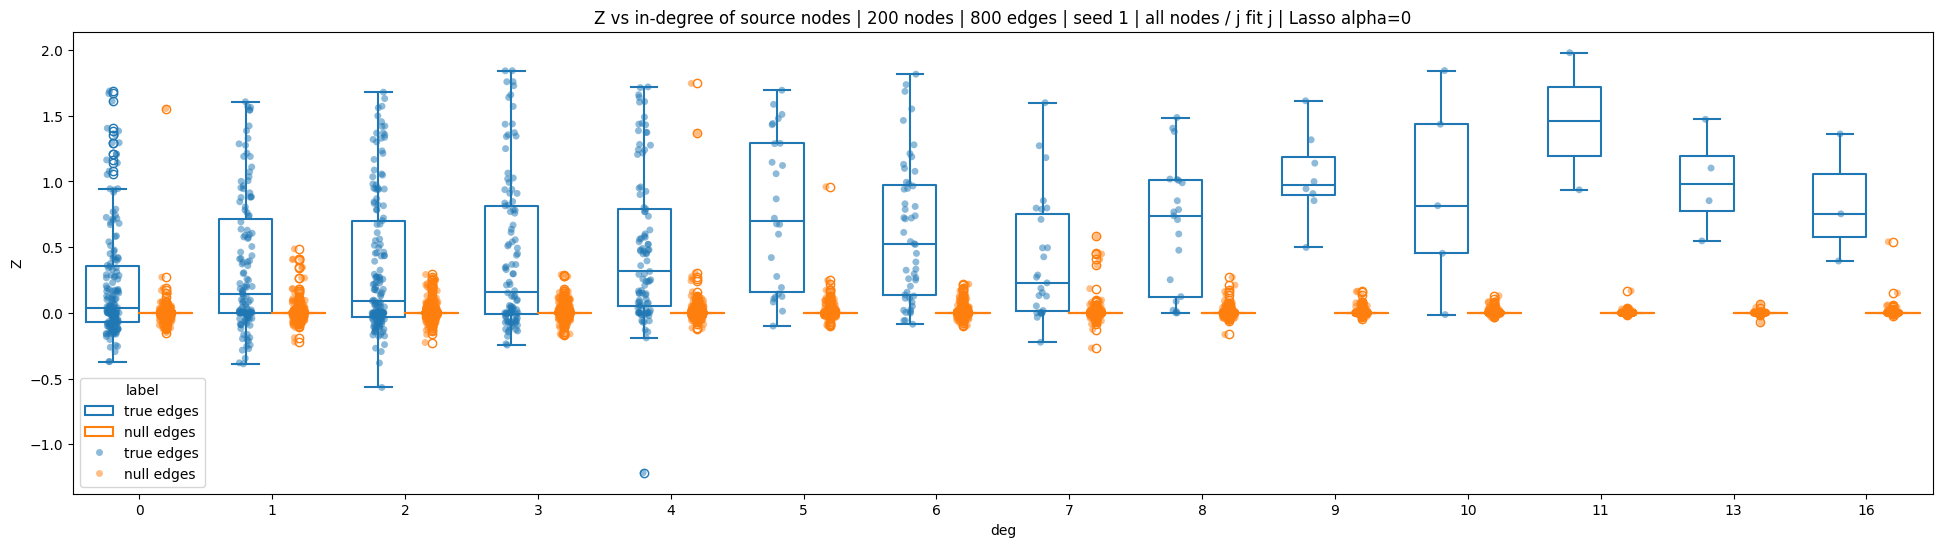

In [11]:
n_nodes = 200
s0 = 4
n_edges = n_nodes * s0
df = sys_z0_vs_deg_box(n_nodes, f'v44/v{n_nodes}_{n_edges}_option_5_lasso_OLS', notes='all nodes / j fit j | Lasso alpha=0', s0=s0)

# 500, 2000

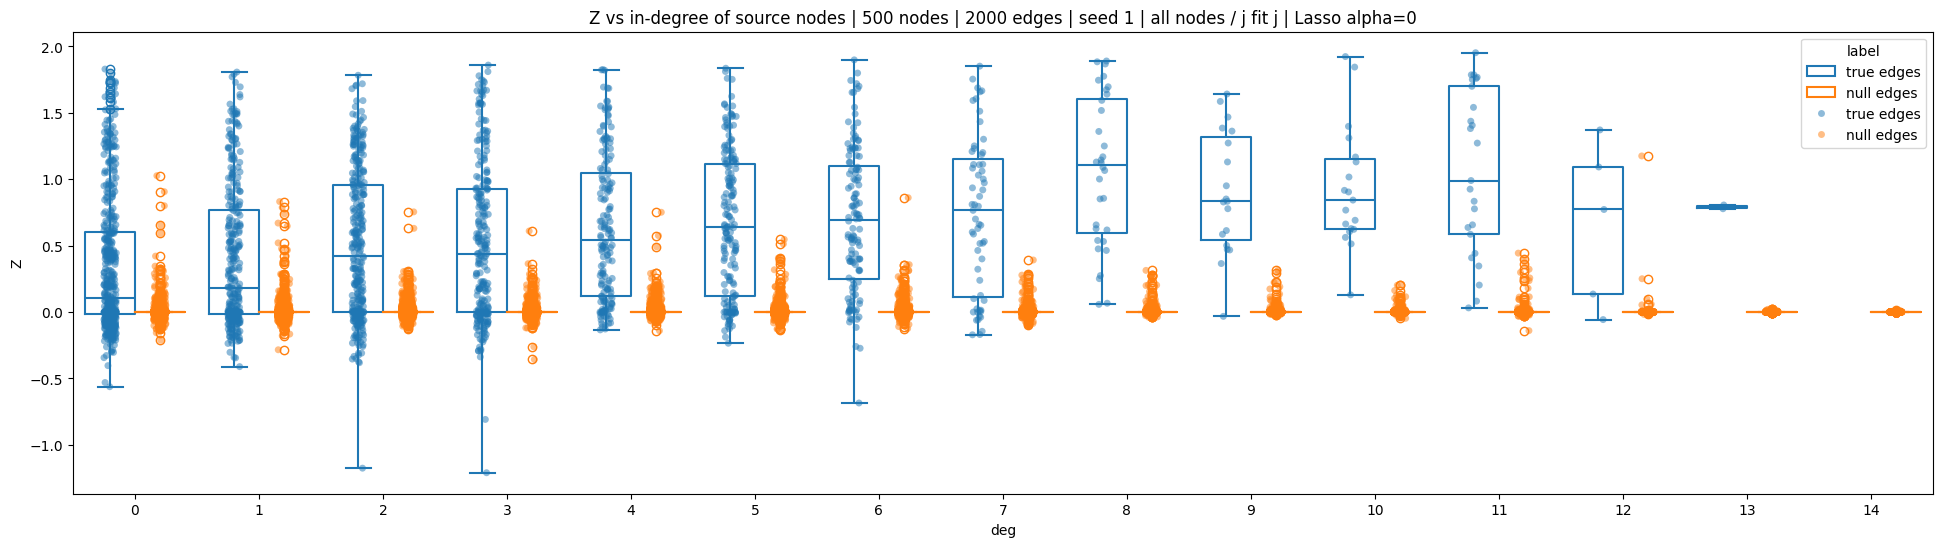

In [12]:
n_nodes = 500
s0 = 4
n_edges = n_nodes * s0
df = sys_z0_vs_deg_box(n_nodes, f'v44/v{n_nodes}_{n_edges}_option_5_lasso_OLS', notes='all nodes / j fit j | Lasso alpha=0', s0=s0)

# 60, 360

## others

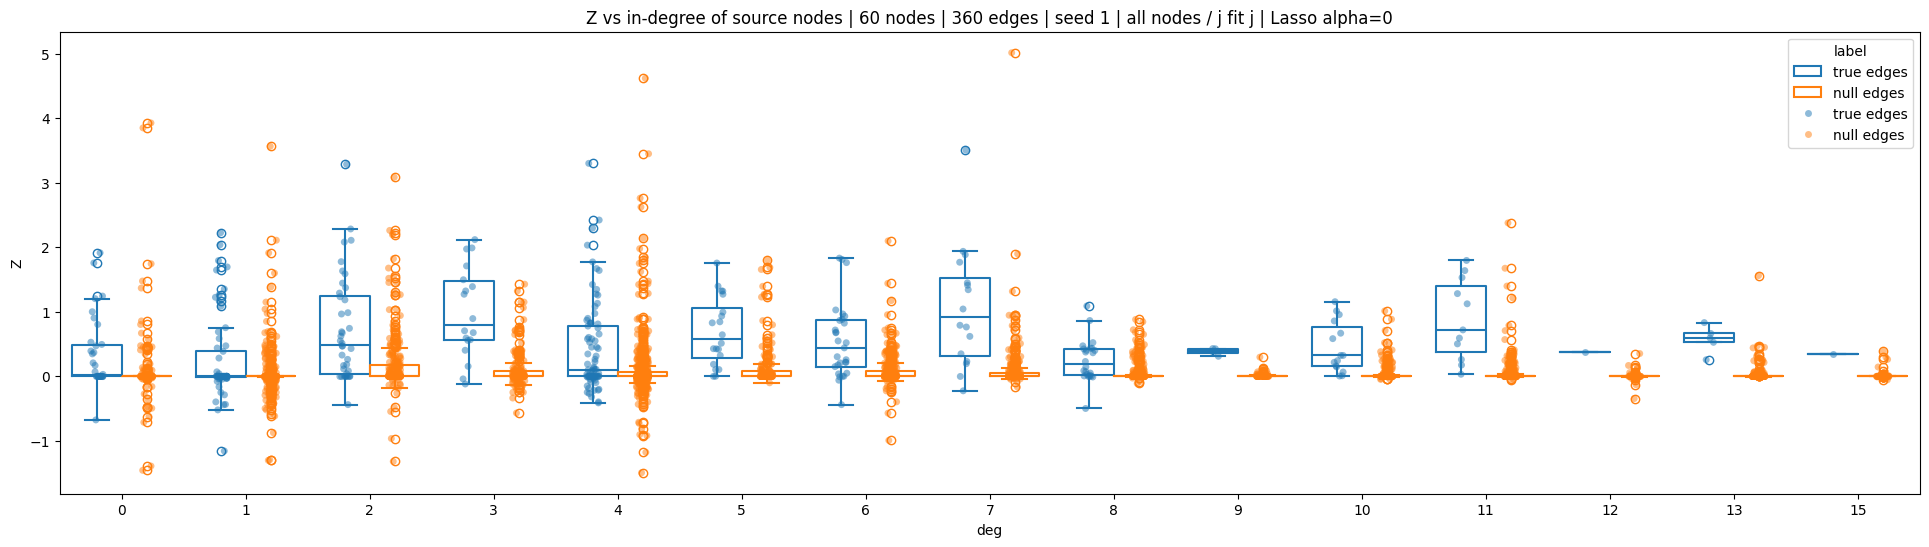

In [39]:
n_nodes = 60
s0 = 6
n_edges = n_nodes * s0
df = sys_z0_vs_deg_box(n_nodes, f'v44/v{n_nodes}_{n_edges}_option_5_lasso_OLS', notes='all nodes / j fit j | Lasso alpha=0', s0=s0)

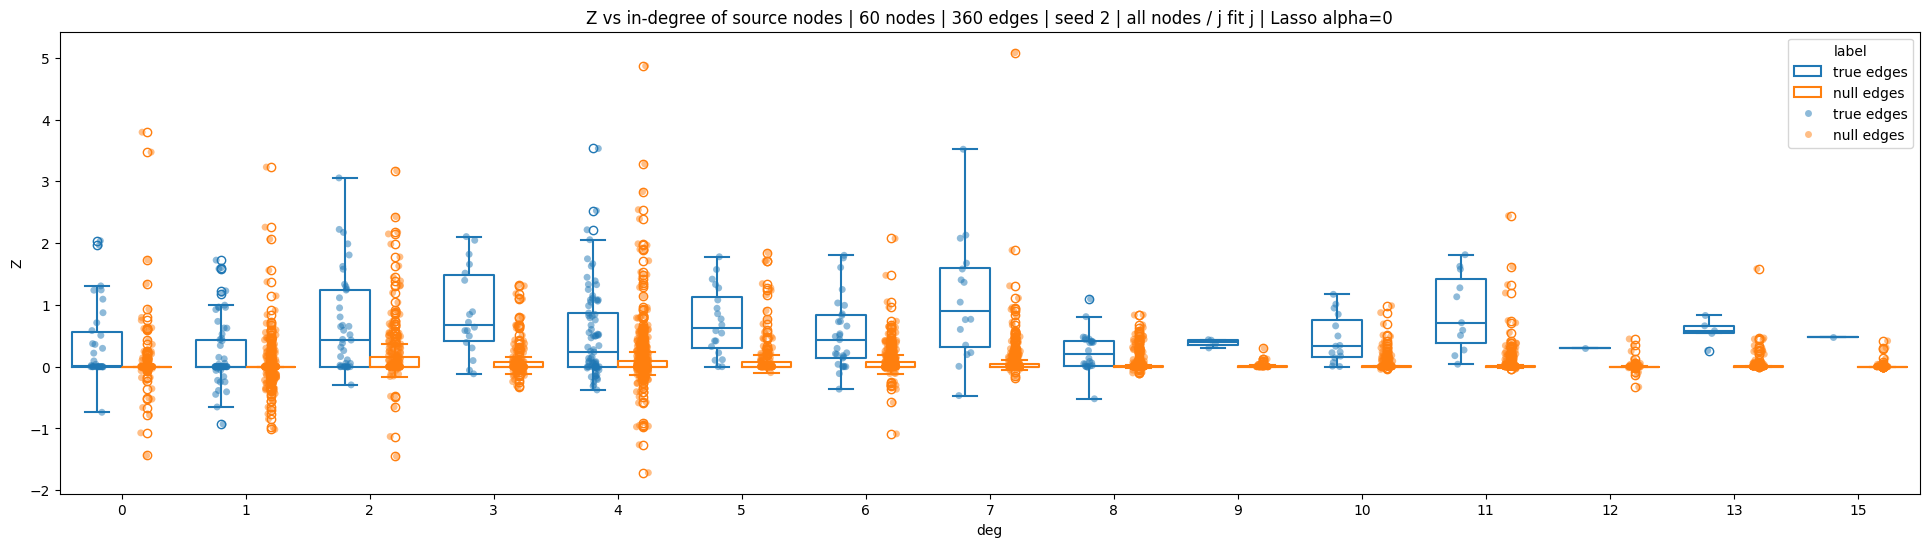

In [51]:
n_nodes = 60
s0 = 6
n_edges = n_nodes * s0
df = sys_z0_vs_deg_box(n_nodes, f'v44/v{n_nodes}_{n_edges}_option_5_lasso_OLS', notes='all nodes / j fit j | Lasso alpha=0', s0=s0, seed=2)

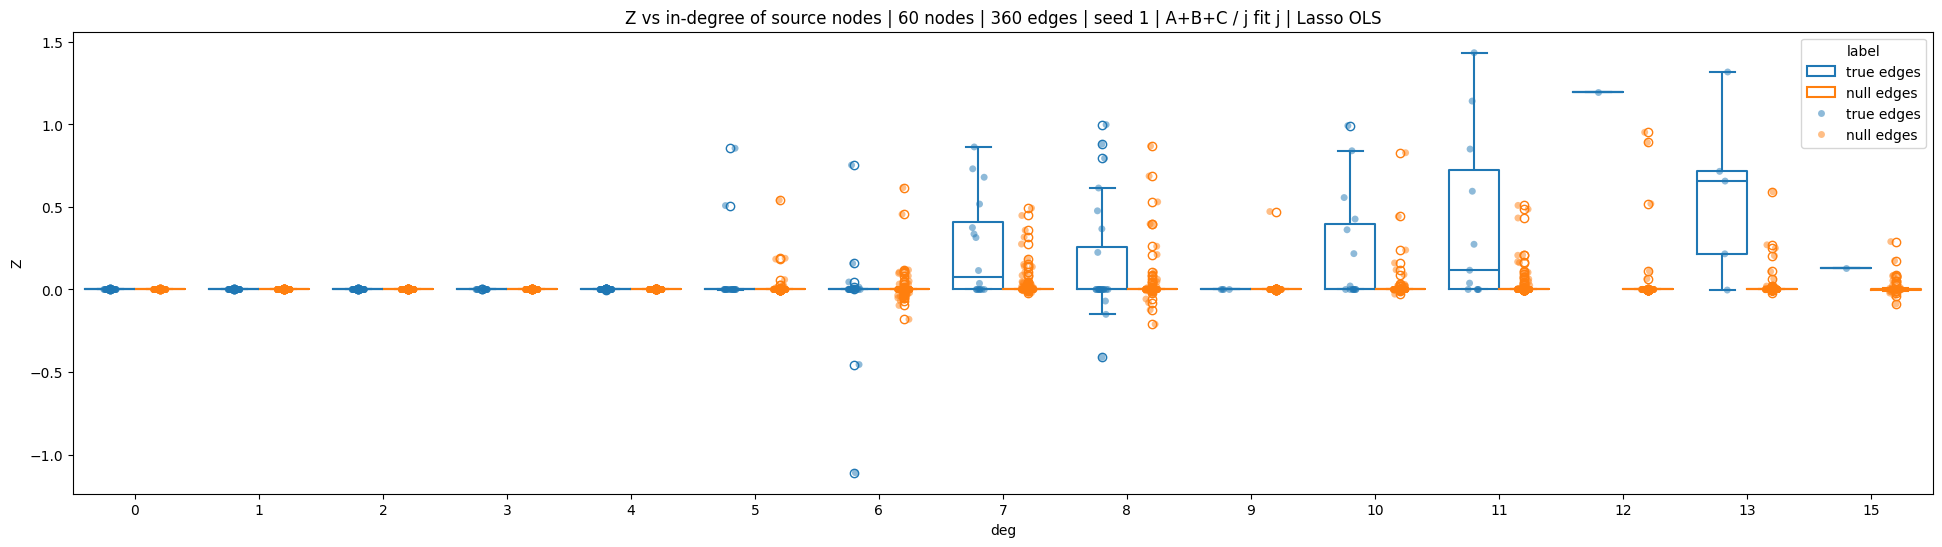

In [41]:
n_nodes = 60
s0 = 6
n_edges = n_nodes * s0
df, W11, W21 = sys_z0_vs_deg_box(n_nodes, f'v44/v{n_nodes}_{n_edges}_option_1_lasso_OLS', notes='A+B+C / j fit j | Lasso OLS', s0=s0)

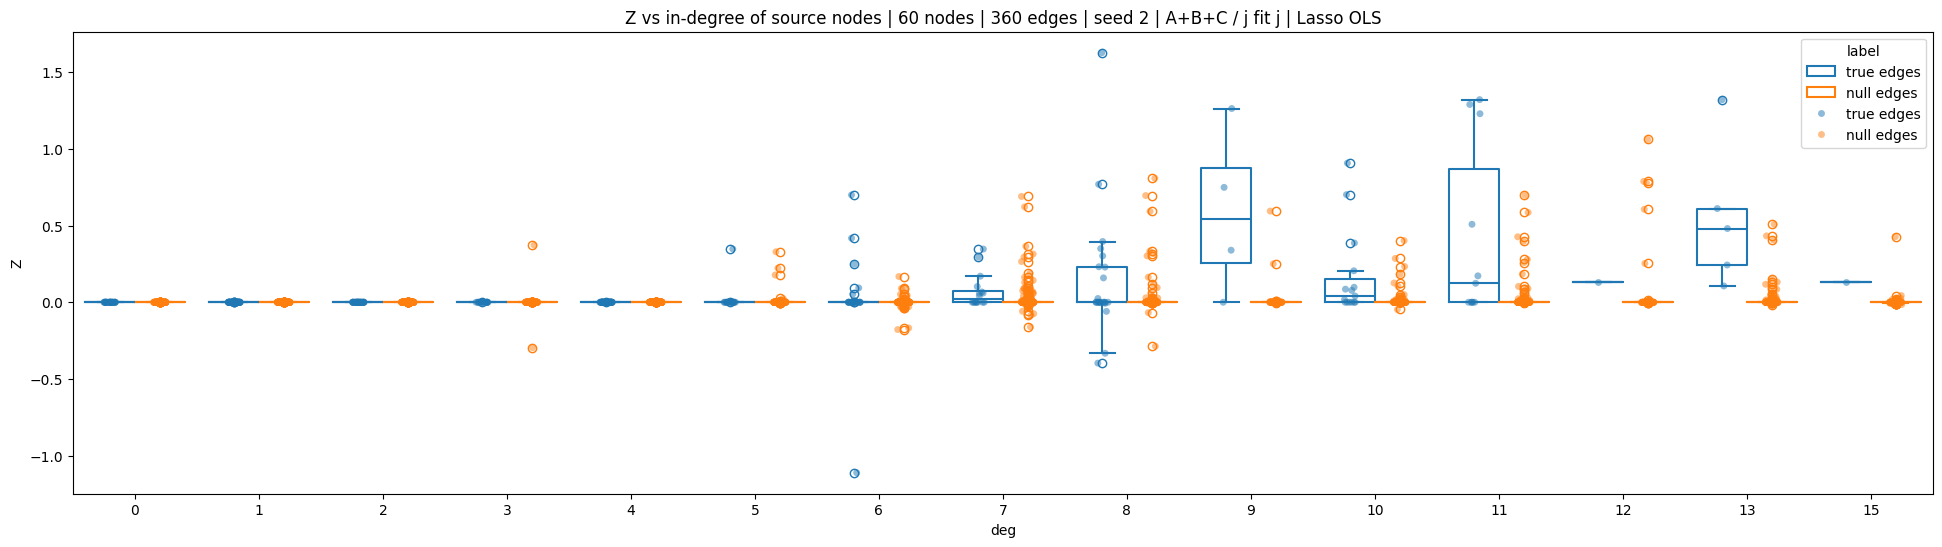

In [42]:
n_nodes = 60
s0 = 6
n_edges = n_nodes * s0
df, W11, W21 = sys_z0_vs_deg_box(n_nodes, f'v44/v{n_nodes}_{n_edges}_option_1_lasso_OLS', notes='A+B+C / j fit j | Lasso OLS', s0=s0, seed=2)

## all nodes / j fit j | OLS, seed=1
* all true fdp > 0.2
* when large threshold, est fdp < true fdp. other cases nice.
* true fdp: 0.8, true power: 0.0056

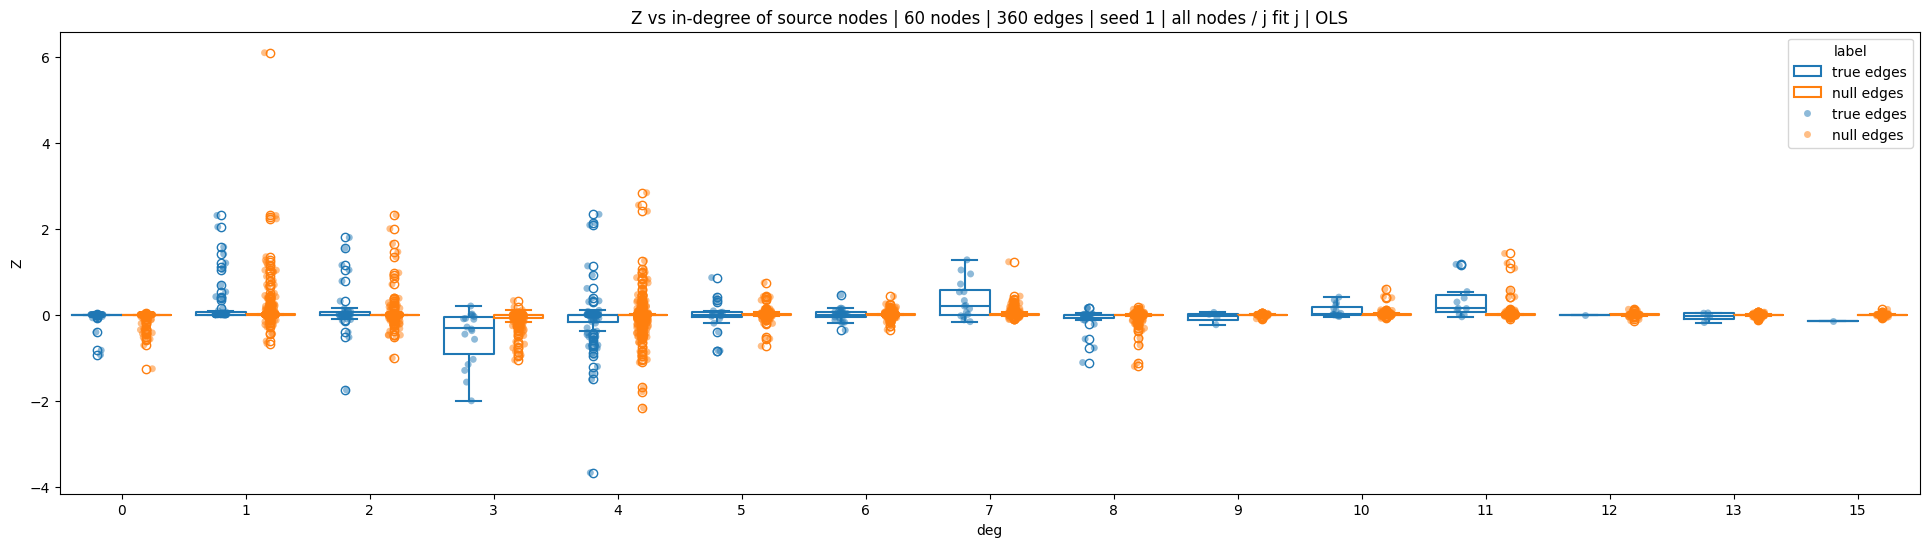

In [85]:
n_nodes = 60
s0 = 6
n_edges = n_nodes * s0
df, W11, W21, W_true, B_true, W_est = sys_z0_vs_deg_box(n_nodes, f'v44/v{n_nodes}_{n_edges}_option_5_OLS', notes='all nodes / j fit j | OLS', s0=s0)

In [51]:
df.Z.max()

6.096638077082547

In [48]:
df.iloc[392]

deg               1
Z          6.096638
label    null edges
Name: 392, dtype: object

In [49]:
Z = np.abs(W11) - np.abs(W21)

In [87]:
np.where(Z == df.Z.max())

(array([18]), array([55]))

In [86]:
Z = np.abs(W11) - np.abs(W21)
np.where(Z == df.loc[df.label == 'true edges'].Z.min())

(array([10]), array([55]))

In [91]:
Z = np.abs(W11) - np.abs(W21)
np.where(Z == df.loc[df.label == 'null edges'].Z.min())

(array([25]), array([43]))

In [11]:
Z = np.abs(W11) - np.abs(W21)
fdr = 0.2
t_list = np.concatenate(([0], np.sort(np.unique(np.abs(Z)))))
t_last = np.inf
fdr_est_last = None
T_T_true = np.abs(W_true)
mask = (T_T_true > 0.)
T_T_true[mask], T_T_true[~mask] = 1, 0

for t in reversed(t_list):
    if t < 0.:
        break
    
    fdr_est = (1 + (Z <= -t).sum()) / np.max((1, (Z >= t).sum()))
    
    T_T = Z.copy()
    mask = (T_T >= t)
    T_T[mask], T_T[~mask] = 1, 0
    perf = utils_dagma.count_accuracy_simplify(T_T_true, T_T)
    fdr_true, power = perf['fdr'], perf['tpr']

    print(f"thresh {t:.4f} | est fdr {fdr_est:.4f} | true fdr {fdr_true:.4f} | true power {power:.4f}")

    if fdr_est <= fdr:
        t_last = t
        fdr_est_last = fdr_est

thresh 6.0966 | est fdr 1.0000 | true fdr 1.0000 | true power 0.0000
thresh 3.6787 | est fdr 2.0000 | true fdr 1.0000 | true power 0.0000
thresh 2.8383 | est fdr 1.0000 | true fdr 1.0000 | true power 0.0000
thresh 2.5500 | est fdr 0.6667 | true fdr 1.0000 | true power 0.0000
thresh 2.4088 | est fdr 0.5000 | true fdr 1.0000 | true power 0.0000
thresh 2.3355 | est fdr 0.4000 | true fdr 0.8000 | true power 0.0028
thresh 2.3218 | est fdr 0.3333 | true fdr 0.8333 | true power 0.0028
thresh 2.3088 | est fdr 0.2857 | true fdr 0.7143 | true power 0.0056
thresh 2.3082 | est fdr 0.2500 | true fdr 0.7500 | true power 0.0056
thresh 2.2831 | est fdr 0.2222 | true fdr 0.7778 | true power 0.0056
thresh 2.2294 | est fdr 0.2000 | true fdr 0.8000 | true power 0.0056
thresh 2.1715 | est fdr 0.3000 | true fdr 0.8000 | true power 0.0056
thresh 2.1400 | est fdr 0.2727 | true fdr 0.7273 | true power 0.0083
thresh 2.0863 | est fdr 0.2500 | true fdr 0.6667 | true power 0.0111
thresh 2.0427 | est fdr 0.2308 | t

## all nodes / j fit j | OLS, seed=2
* all true fdp > 0.2
* est fdp always > true fdp
* no edges being selected

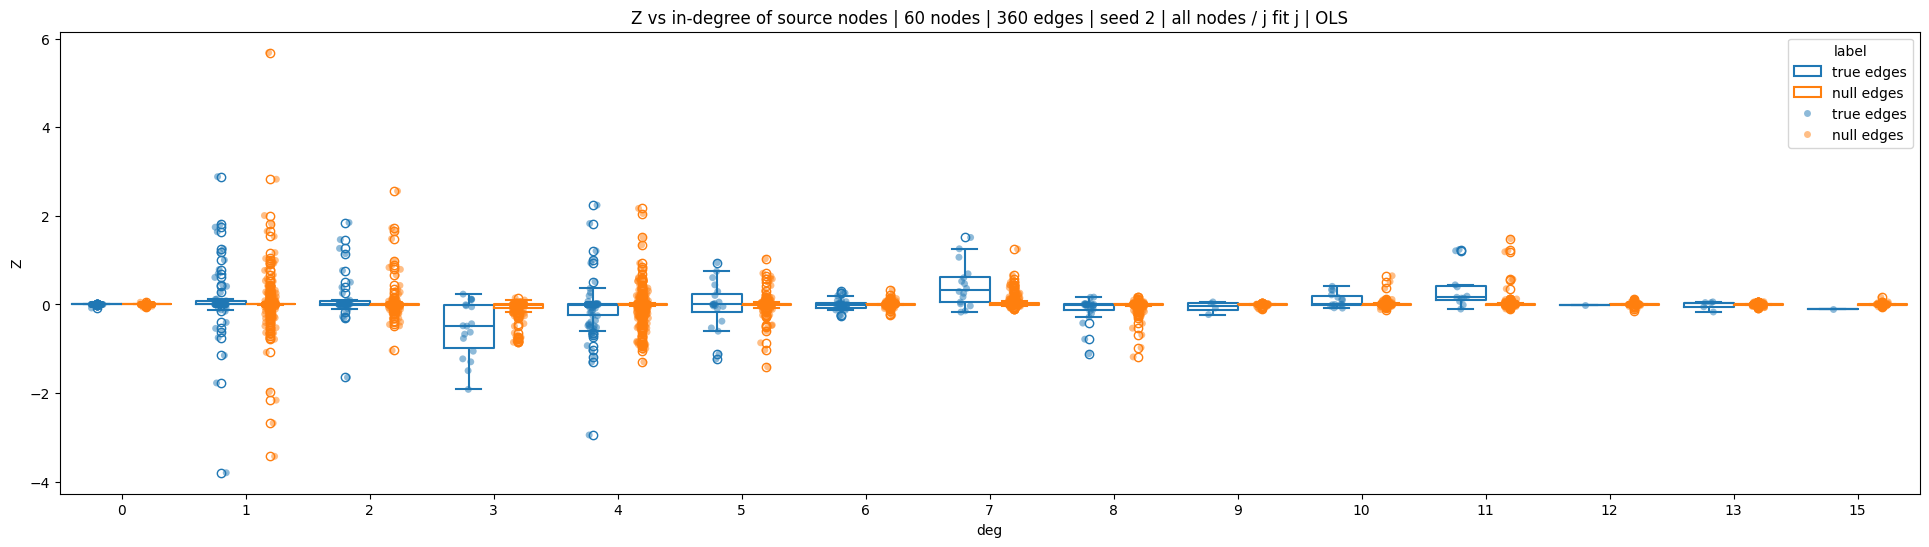

In [155]:
n_nodes = 60
s0 = 6
n_edges = n_nodes * s0
df, W11, W21, W_true, B_true, W_est, X = sys_z0_vs_deg_box(n_nodes, f'v44/v{n_nodes}_{n_edges}_option_5_OLS', notes='all nodes / j fit j | OLS', s0=s0, seed=2)
X_tilde = load_knockoff(n_nodes, 2, f'v44/v{n_nodes}_{n_edges}_option_5_OLS')

In [112]:
G = nx.DiGraph(Z)
nx.write_gexf(G, "/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v44/v60_360_option_5_OLS/W/Z_graph_2_0.gexf")

Z_null = Z.copy()
Z_null[B_true] = 0.
G_null = nx.DiGraph(Z_null)
nx.write_gexf(G_null, "/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v44/v60_360_option_5_OLS/W/Z_null_graph_2_0.gexf")

G_true = nx.DiGraph(W_true)
nx.write_gexf(G_true, "/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v44/v60_360_option_5_OLS/W/Z_true_graph_2_0.gexf")

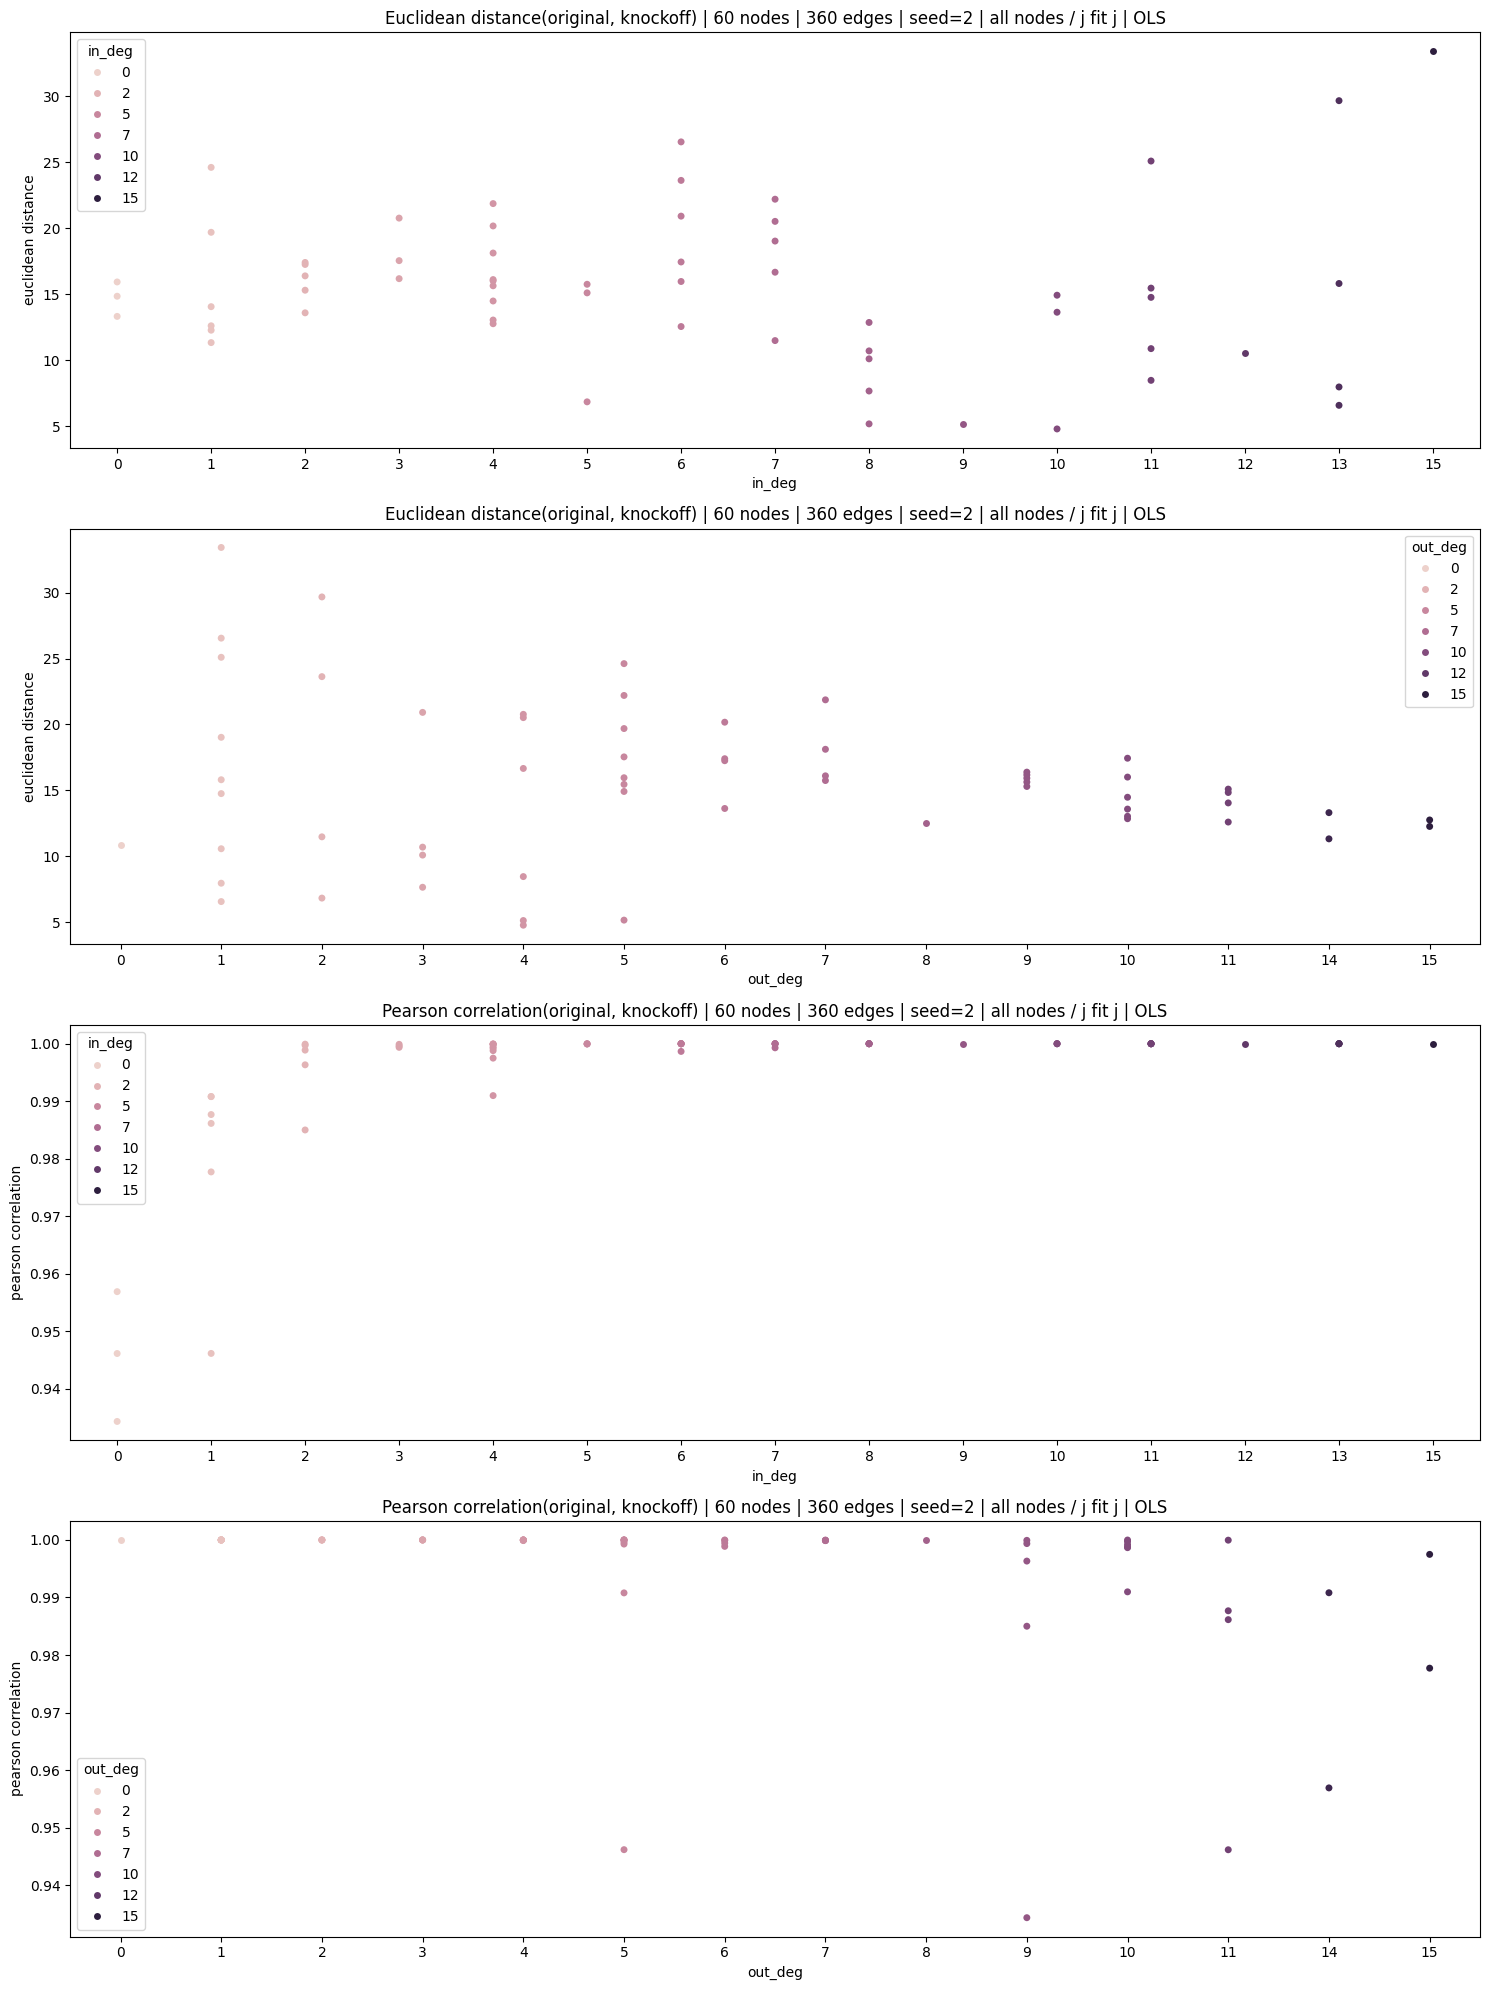

In [198]:
out_deg = B_true.sum(axis=1)
in_deg = B_true.sum(axis=0)

fig, axs = plt.subplots(4, 1, figsize=(15, 20))
data_dict = {
    'in_deg': in_deg,
    'euclidean distance': np.linalg.norm(X - X_tilde, axis=0)
}
sns.stripplot(data_dict, x='in_deg', y='euclidean distance', jitter=False, hue='in_deg', ax=axs[0])
axs[0].set_title("Euclidean distance(original, knockoff) | 60 nodes | 360 edges | seed=2 | all nodes / j fit j | OLS")


data_dict = {
    'out_deg': out_deg,
    'euclidean distance': np.linalg.norm(X - X_tilde, axis=0)
}
sns.stripplot(data_dict, x='out_deg', y='euclidean distance', jitter=False, hue='out_deg', ax=axs[1])
axs[1].set_title("Euclidean distance(original, knockoff) | 60 nodes | 360 edges | seed=2 | all nodes / j fit j | OLS")

corr = np.corrcoef(np.concatenate([X, X_tilde], axis=1).T)
corr = np.diag(corr[:60, 60:])
data_dict = {
    'in_deg': in_deg,
    'pearson correlation': corr
}
sns.stripplot(data_dict, x='in_deg', y='pearson correlation', jitter=False, hue='in_deg', ax=axs[2])
axs[2].set_title("Pearson correlation(original, knockoff) | 60 nodes | 360 edges | seed=2 | all nodes / j fit j | OLS")

corr = np.corrcoef(np.concatenate([X, X_tilde], axis=1).T)
corr = np.diag(corr[:60, 60:])
data_dict = {
    'out_deg': out_deg,
    'pearson correlation': corr
}
sns.stripplot(data_dict, x='out_deg', y='pearson correlation', jitter=False, hue='out_deg', ax=axs[3])
axs[3].set_title("Pearson correlation(original, knockoff) | 60 nodes | 360 edges | seed=2 | all nodes / j fit j | OLS")
plt.tight_layout()

In [8]:
Z = np.abs(W11) - np.abs(W21)
fdr = 0.2
t_list = np.concatenate(([0], np.sort(np.unique(np.abs(Z)))))
t_last = np.inf
fdr_est_last = None
T_T_true = np.abs(W_true)
mask = (T_T_true > 0.)
T_T_true[mask], T_T_true[~mask] = 1, 0

for t in reversed(t_list):
    if t < 0.:
        break
    
    fdr_est = (1 + (Z <= -t).sum()) / np.max((1, (Z >= t).sum()))
    
    T_T = Z.copy()
    mask = (T_T >= t)
    T_T[mask], T_T[~mask] = 1, 0
    perf = utils_dagma.count_accuracy_simplify(T_T_true, T_T)
    fdr_true, power = perf['fdr'], perf['tpr']

    print(f"thresh {t:.4f} | est fdr {fdr_est:.4f} | true fdr {fdr_true:.4f} | true power {power:.4f}")

    if fdr_est <= fdr:
        t_last = t
        fdr_est_last = fdr_est

thresh 5.6804 | est fdr 1.0000 | true fdr 1.0000 | true power 0.0000
thresh 3.7955 | est fdr 2.0000 | true fdr 1.0000 | true power 0.0000
thresh 3.4251 | est fdr 3.0000 | true fdr 1.0000 | true power 0.0000
thresh 2.9441 | est fdr 4.0000 | true fdr 1.0000 | true power 0.0000
thresh 2.8836 | est fdr 2.0000 | true fdr 0.5000 | true power 0.0028
thresh 2.8262 | est fdr 1.3333 | true fdr 0.6667 | true power 0.0028
thresh 2.6760 | est fdr 1.6667 | true fdr 0.6667 | true power 0.0028
thresh 2.5589 | est fdr 1.2500 | true fdr 0.7500 | true power 0.0028
thresh 2.2415 | est fdr 1.0000 | true fdr 0.6000 | true power 0.0056
thresh 2.1677 | est fdr 0.8333 | true fdr 0.6667 | true power 0.0056
thresh 2.1590 | est fdr 1.0000 | true fdr 0.6667 | true power 0.0056
thresh 2.0525 | est fdr 0.8571 | true fdr 0.7143 | true power 0.0056
thresh 2.0077 | est fdr 0.7500 | true fdr 0.7500 | true power 0.0056
thresh 1.9668 | est fdr 0.8750 | true fdr 0.7500 | true power 0.0056
thresh 1.9150 | est fdr 1.0000 | t

## all nodes / j fit j | OLS, seed=3
* all true fdp > 0.2
* when large threshold, est fdp < true fdp. other cases nice.
* no edges being selected

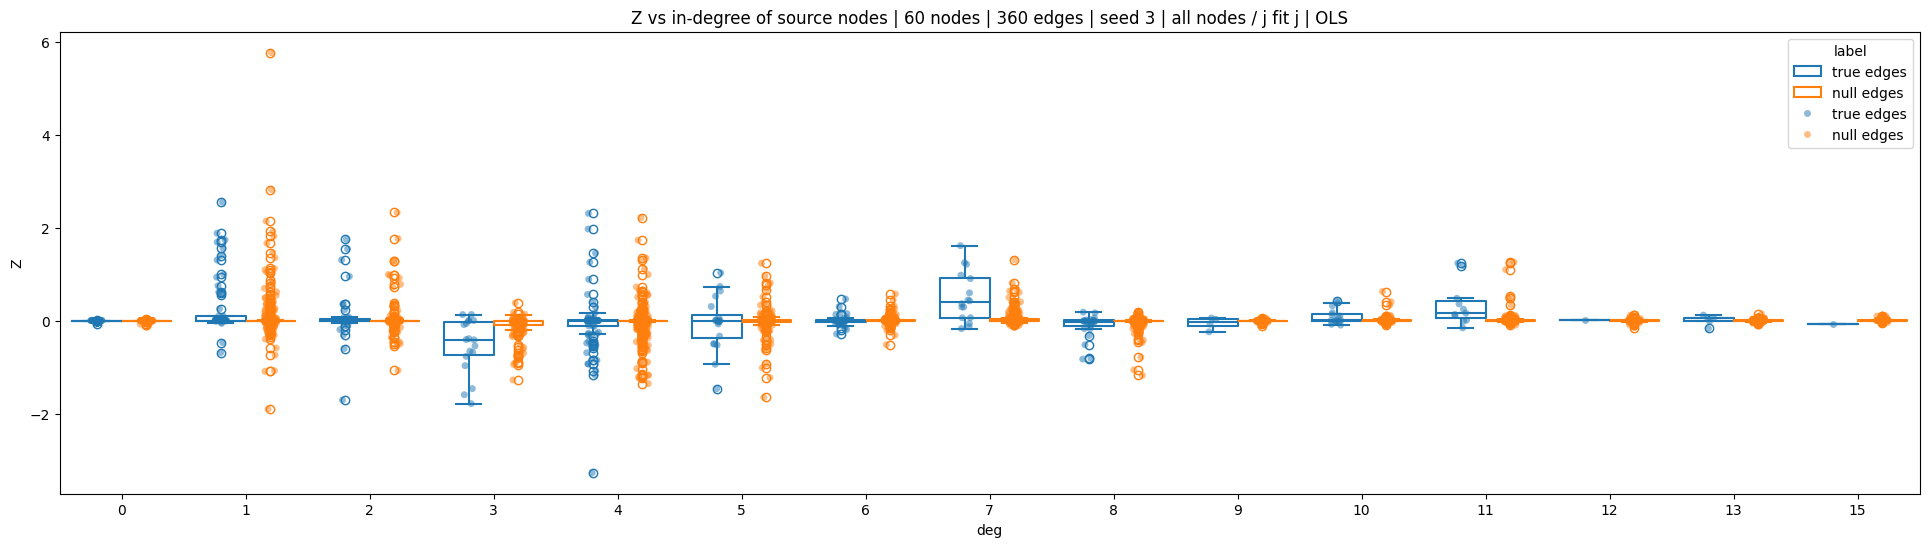

In [80]:
n_nodes = 60
s0 = 6
n_edges = n_nodes * s0
df, W11, W21, W_true, B_true, W_est = sys_z0_vs_deg_box(n_nodes, f'v44/v{n_nodes}_{n_edges}_option_5_OLS', notes='all nodes / j fit j | OLS', s0=s0, seed=3)

In [81]:
Z = np.abs(W11) - np.abs(W21)
np.where(Z == df.Z.max())

(array([18]), array([55]))

In [82]:
Z = np.abs(W11) - np.abs(W21)
np.where(Z == df.loc[df.label == 'true edges'].Z.min())

(array([10]), array([55]))

In [83]:
Z = np.abs(W11) - np.abs(W21)
np.where(Z == df.loc[df.label == 'null edges'].Z.min())

(array([0]), array([43]))

In [14]:
Z = np.abs(W11) - np.abs(W21)
fdr = 0.2
t_list = np.concatenate(([0], np.sort(np.unique(np.abs(Z)))))
t_last = np.inf
fdr_est_last = None
T_T_true = np.abs(W_true)
mask = (T_T_true > 0.)
T_T_true[mask], T_T_true[~mask] = 1, 0

for t in reversed(t_list):
    if t < 0.:
        break
    
    fdr_est = (1 + (Z <= -t).sum()) / np.max((1, (Z >= t).sum()))
    
    T_T = Z.copy()
    mask = (T_T >= t)
    T_T[mask], T_T[~mask] = 1, 0
    perf = utils_dagma.count_accuracy_simplify(T_T_true, T_T)
    fdr_true, power = perf['fdr'], perf['tpr']

    print(f"thresh {t:.4f} | est fdr {fdr_est:.4f} | true fdr {fdr_true:.4f} | true power {power:.4f}")

    if fdr_est <= fdr:
        t_last = t
        fdr_est_last = fdr_est

thresh 5.7620 | est fdr 1.0000 | true fdr 1.0000 | true power 0.0000
thresh 3.2727 | est fdr 2.0000 | true fdr 1.0000 | true power 0.0000
thresh 2.8187 | est fdr 1.0000 | true fdr 1.0000 | true power 0.0000
thresh 2.5485 | est fdr 0.6667 | true fdr 0.6667 | true power 0.0028
thresh 2.3251 | est fdr 0.5000 | true fdr 0.7500 | true power 0.0028
thresh 2.3057 | est fdr 0.4000 | true fdr 0.6000 | true power 0.0056
thresh 2.2154 | est fdr 0.3333 | true fdr 0.6667 | true power 0.0056
thresh 2.1392 | est fdr 0.2857 | true fdr 0.7143 | true power 0.0056
thresh 1.9700 | est fdr 0.2500 | true fdr 0.6250 | true power 0.0083
thresh 1.9190 | est fdr 0.2222 | true fdr 0.6667 | true power 0.0083
thresh 1.9017 | est fdr 0.3333 | true fdr 0.6667 | true power 0.0083
thresh 1.8799 | est fdr 0.3000 | true fdr 0.6000 | true power 0.0111
thresh 1.8167 | est fdr 0.2727 | true fdr 0.6364 | true power 0.0111
thresh 1.7868 | est fdr 0.3636 | true fdr 0.6364 | true power 0.0111
thresh 1.7655 | est fdr 0.3333 | t

## all nodes / j fit j | OLS, seed=4
* all true fdp > 0.2
* when large threshold, est fdp < true fdp. other cases nice.
* true fdp: 0.5833, true power: 0.0139

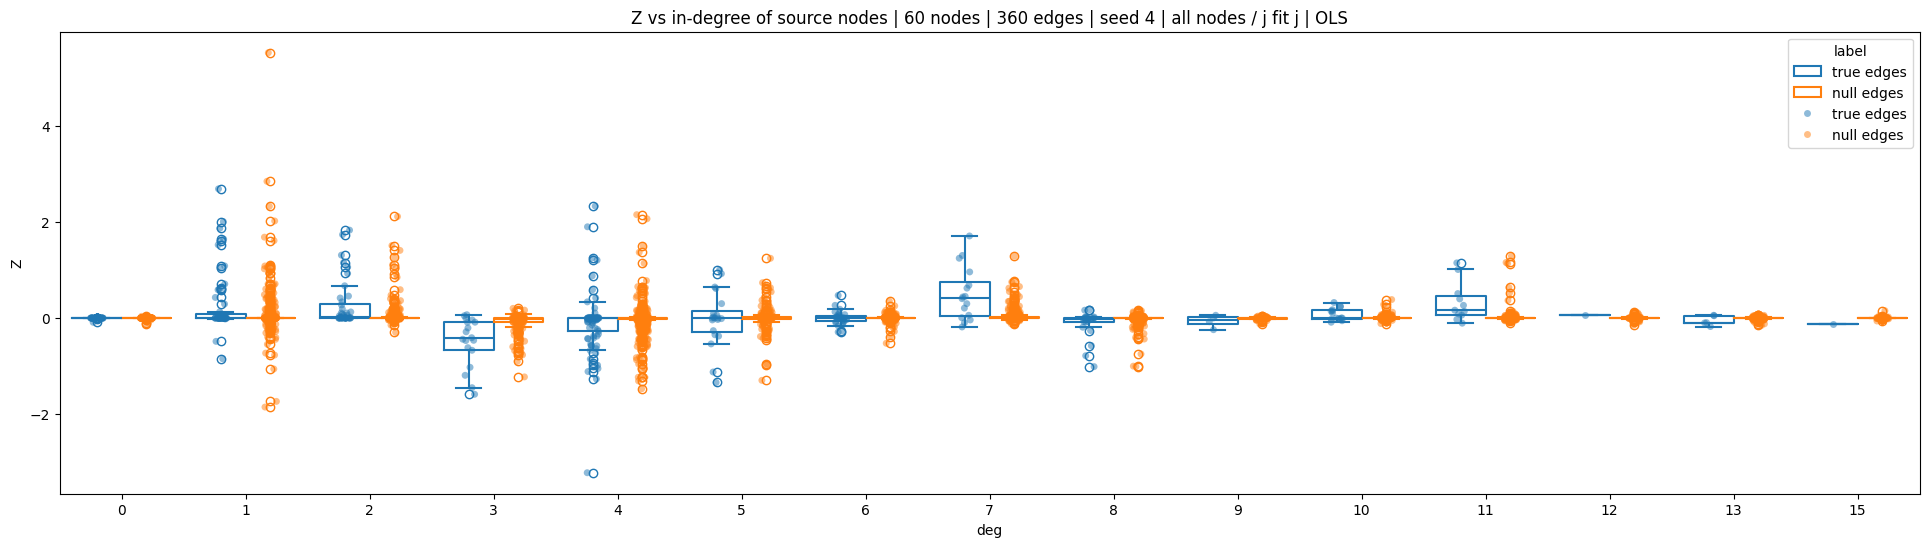

In [18]:
n_nodes = 60
s0 = 6
n_edges = n_nodes * s0
df, W11, W21, W_true = sys_z0_vs_deg_box(n_nodes, f'v44/v{n_nodes}_{n_edges}_option_5_OLS', notes='all nodes / j fit j | OLS', s0=s0, seed=4)

In [19]:
Z = np.abs(W11) - np.abs(W21)
fdr = 0.2
t_list = np.concatenate(([0], np.sort(np.unique(np.abs(Z)))))
t_last = np.inf
fdr_est_last = None
T_T_true = np.abs(W_true)
mask = (T_T_true > 0.)
T_T_true[mask], T_T_true[~mask] = 1, 0

for t in reversed(t_list):
    if t < 0.:
        break
    
    fdr_est = (1 + (Z <= -t).sum()) / np.max((1, (Z >= t).sum()))
    
    T_T = Z.copy()
    mask = (T_T >= t)
    T_T[mask], T_T[~mask] = 1, 0
    perf = utils_dagma.count_accuracy_simplify(T_T_true, T_T)
    fdr_true, power = perf['fdr'], perf['tpr']

    print(f"thresh {t:.4f} | est fdr {fdr_est:.4f} | true fdr {fdr_true:.4f} | true power {power:.4f}")

    if fdr_est <= fdr:
        t_last = t
        fdr_est_last = fdr_est

thresh 5.5226 | est fdr 1.0000 | true fdr 1.0000 | true power 0.0000
thresh 3.2186 | est fdr 2.0000 | true fdr 1.0000 | true power 0.0000
thresh 2.8463 | est fdr 1.0000 | true fdr 1.0000 | true power 0.0000
thresh 2.6894 | est fdr 0.6667 | true fdr 0.6667 | true power 0.0028
thresh 2.3307 | est fdr 0.5000 | true fdr 0.5000 | true power 0.0056
thresh 2.3265 | est fdr 0.4000 | true fdr 0.6000 | true power 0.0056
thresh 2.1520 | est fdr 0.3333 | true fdr 0.6667 | true power 0.0056
thresh 2.1142 | est fdr 0.2857 | true fdr 0.7143 | true power 0.0056
thresh 2.0668 | est fdr 0.2500 | true fdr 0.7500 | true power 0.0056
thresh 2.0211 | est fdr 0.2222 | true fdr 0.7778 | true power 0.0056
thresh 2.0071 | est fdr 0.2000 | true fdr 0.7000 | true power 0.0083
thresh 1.8999 | est fdr 0.1818 | true fdr 0.6364 | true power 0.0111
thresh 1.8678 | est fdr 0.1667 | true fdr 0.5833 | true power 0.0139
thresh 1.8518 | est fdr 0.2500 | true fdr 0.5833 | true power 0.0139
thresh 1.8302 | est fdr 0.2308 | t

## all nodes / j fit j | OLS, seed=5
* all true fdp > 0.2
* when large threshold, est fdp < true fdp. other cases nice.
* true fdp: 0.5556, true power: 0.0222

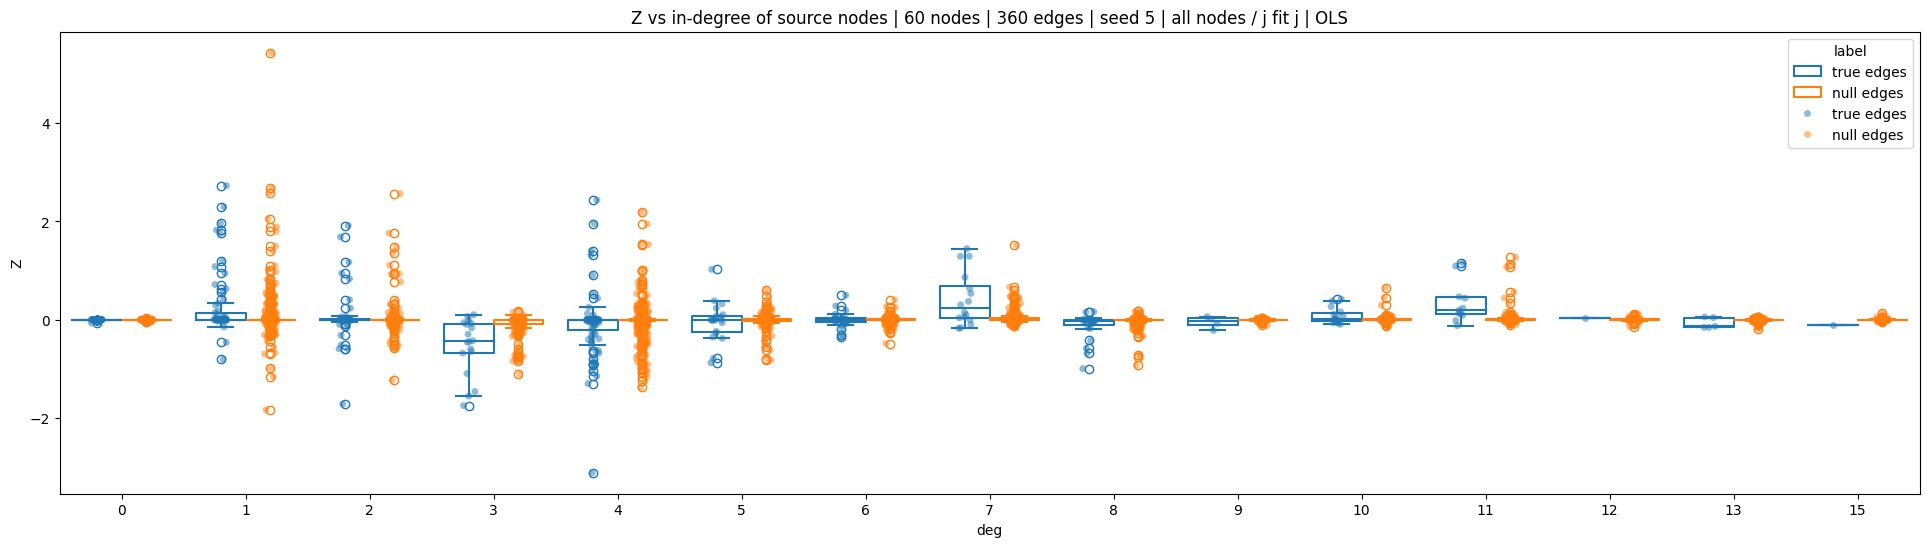

In [376]:
n_nodes = 60
s0 = 6
n_edges = n_nodes * s0
df, W11, W21, W_true, B_true, W_est, X = sys_z0_vs_deg_box(n_nodes, f'v44/v{n_nodes}_{n_edges}_option_5_OLS', notes='all nodes / j fit j | OLS', s0=s0, seed=5)
X_tilde = load_knockoff(n_nodes, 2, f'v44/v{n_nodes}_{n_edges}_option_5_OLS')
Z = np.abs(W11) - np.abs(W21)
in_deg = B_true.sum(axis=0)
out_deg = B_true.sum(axis=1)

G_Z = nx.DiGraph(Z)
nx.write_gexf(G, "/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v44/v60_360_option_5_OLS/W/Z_graph_5_0.gexf")

Z_null = Z.copy()
Z_null[B_true] = 0.
G_Z_null = nx.DiGraph(Z_null)
nx.write_gexf(G_null, "/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v44/v60_360_option_5_OLS/W/Z_null_graph_5_0.gexf")

G_true = nx.DiGraph(W_true)
G_Btrue = nx.DiGraph(B_true)

G_est = nx.DiGraph(W_est)
G11 = nx.DiGraph(W11)
G21 = nx.DiGraph(W21)

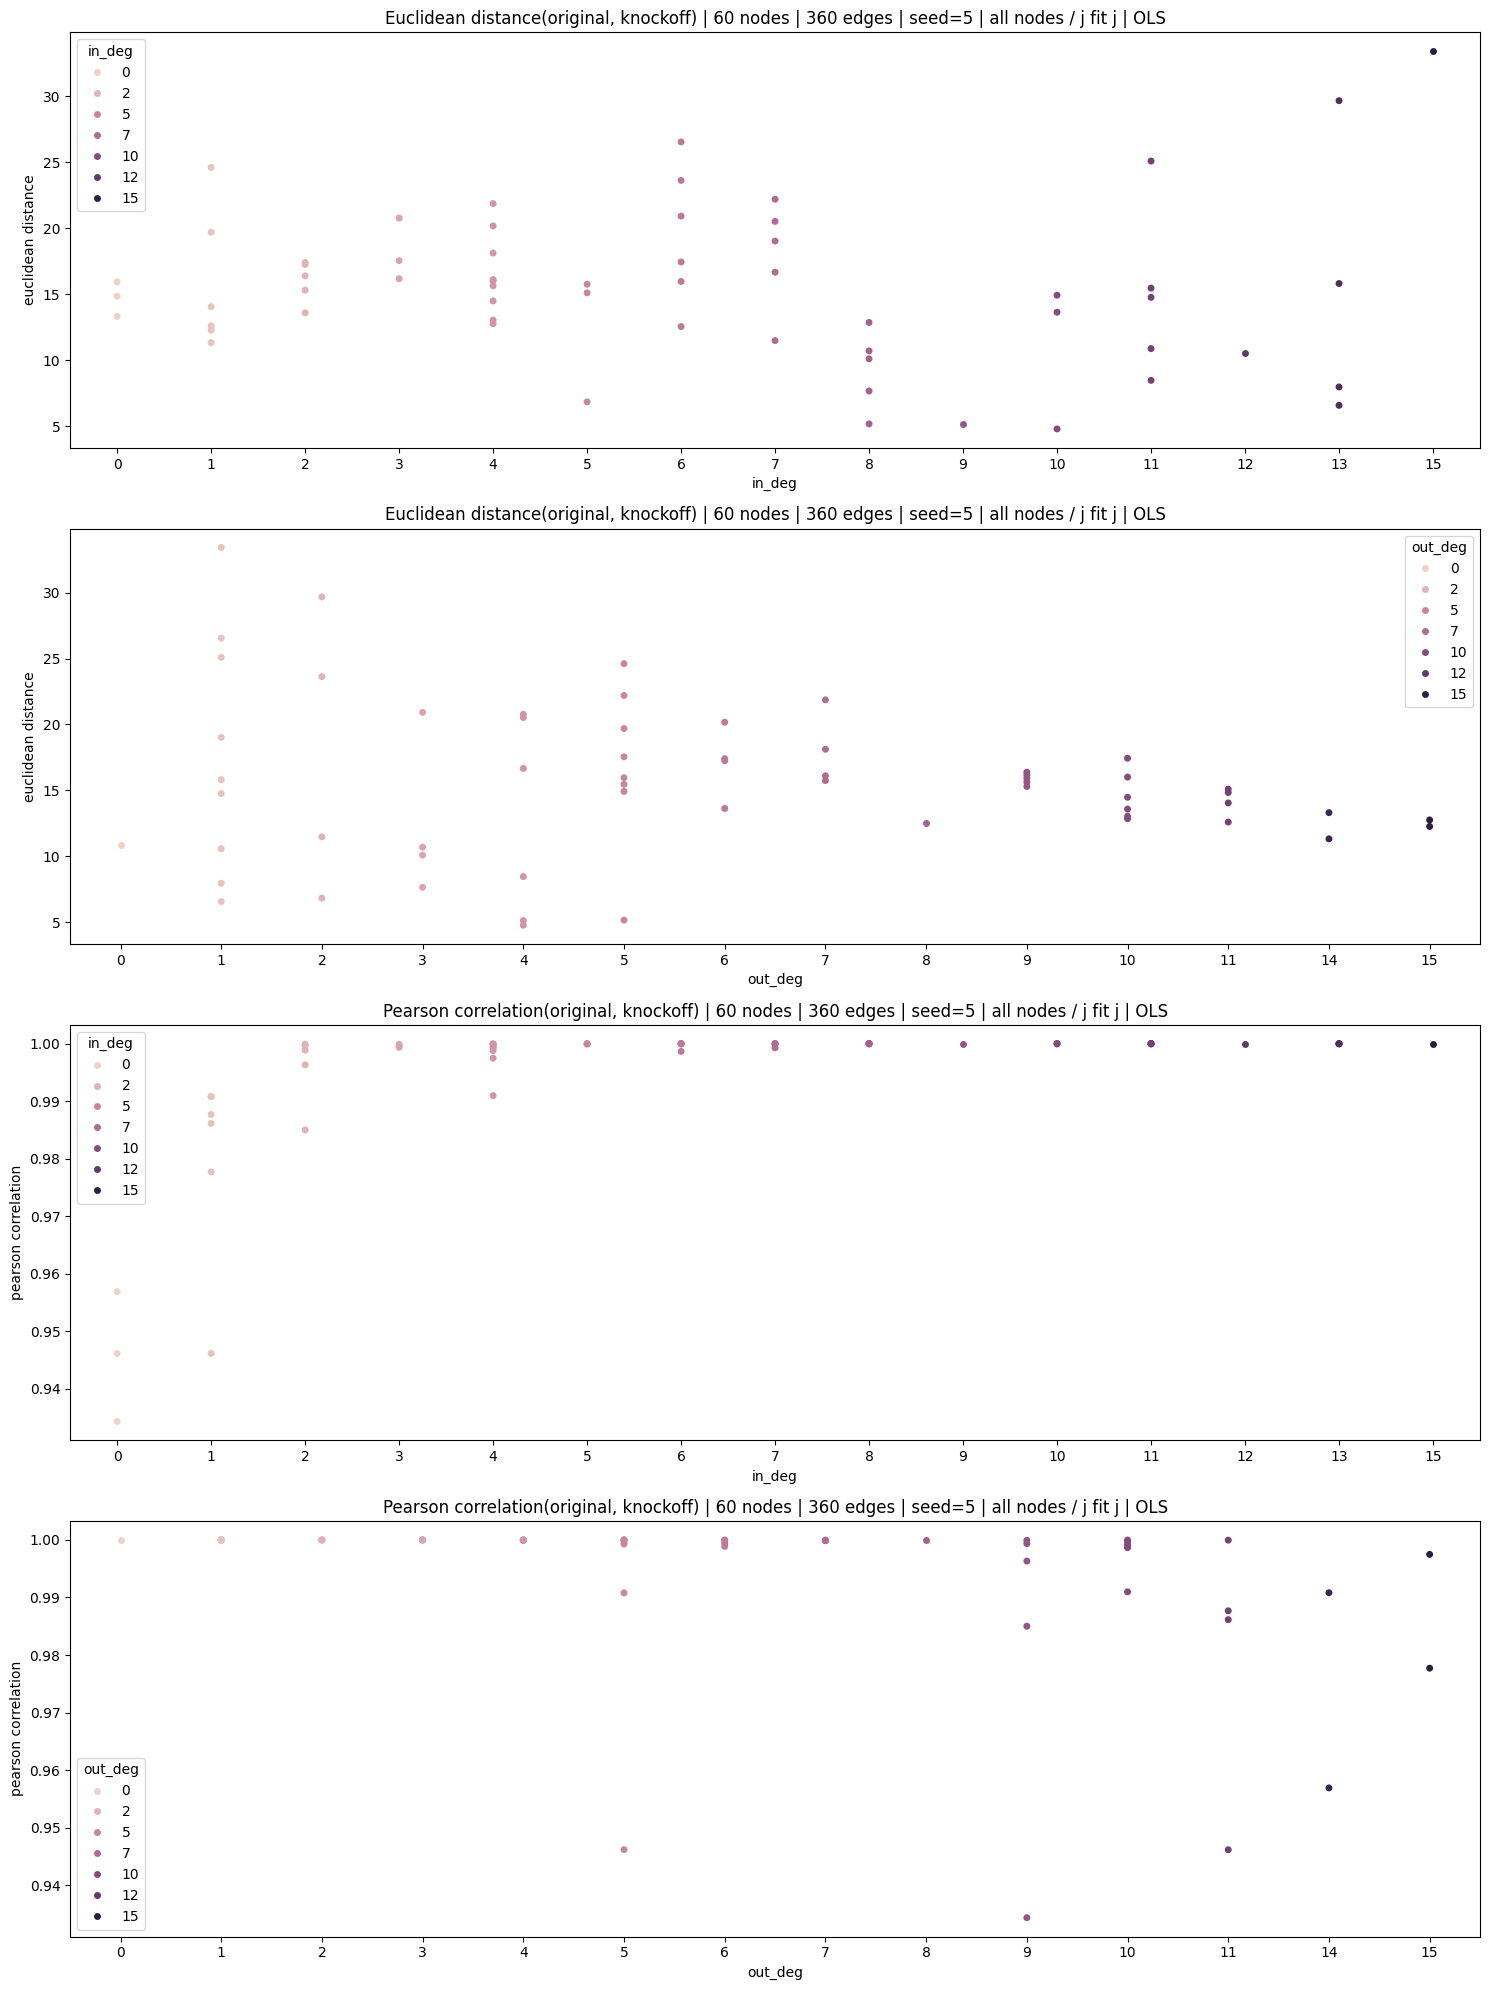

In [370]:
out_deg = B_true.sum(axis=1)
in_deg = B_true.sum(axis=0)

fig, axs = plt.subplots(4, 1, figsize=(15, 20))
data_dict = {
    'in_deg': in_deg,
    'euclidean distance': np.linalg.norm(X - X_tilde, axis=0)
}
sns.stripplot(data_dict, x='in_deg', y='euclidean distance', jitter=False, hue='in_deg', ax=axs[0])
axs[0].set_title("Euclidean distance(original, knockoff) | 60 nodes | 360 edges | seed=5 | all nodes / j fit j | OLS")


data_dict = {
    'out_deg': out_deg,
    'euclidean distance': np.linalg.norm(X - X_tilde, axis=0)
}
sns.stripplot(data_dict, x='out_deg', y='euclidean distance', jitter=False, hue='out_deg', ax=axs[1])
axs[1].set_title("Euclidean distance(original, knockoff) | 60 nodes | 360 edges | seed=5 | all nodes / j fit j | OLS")

corr = np.corrcoef(np.concatenate([X, X_tilde], axis=1).T)
corr = np.diag(corr[:60, 60:])
data_dict = {
    'in_deg': in_deg,
    'pearson correlation': corr
}
sns.stripplot(data_dict, x='in_deg', y='pearson correlation', jitter=False, hue='in_deg', ax=axs[2])
axs[2].set_title("Pearson correlation(original, knockoff) | 60 nodes | 360 edges | seed=5 | all nodes / j fit j | OLS")

corr = np.corrcoef(np.concatenate([X, X_tilde], axis=1).T)
corr = np.diag(corr[:60, 60:])
data_dict = {
    'out_deg': out_deg,
    'pearson correlation': corr
}
sns.stripplot(data_dict, x='out_deg', y='pearson correlation', jitter=False, hue='out_deg', ax=axs[3])
axs[3].set_title("Pearson correlation(original, knockoff) | 60 nodes | 360 edges | seed=5 | all nodes / j fit j | OLS")
plt.tight_layout()

Text(0.5, 1.0, '60 nodes, 360 edges | all nodes / j fit j | OLS, seed=5 | weights from W11')

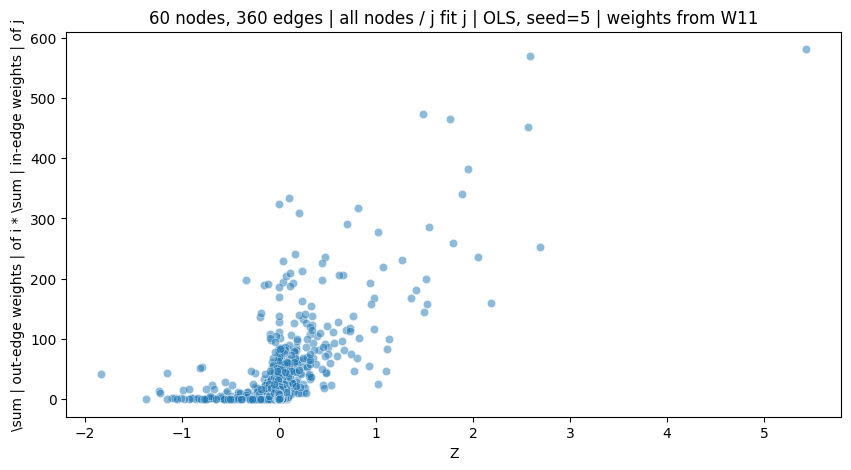

In [380]:
plt.figure(figsize=(10, 5))
n_out_w = {}
n_in_w = {}

for n in G_true.nodes:
    n_out_w[n] = 0.
    n_in_w[n] = 0.
    for _, j, w in G11.out_edges(n, data='weight'):
        n_out_w[n] += abs(w)
    for i, _, w in G11.in_edges(n, data='weight'):
        n_in_w[n] += abs(w)

Z_2_inout_deg = {}
for i, j, z in G_Z_null.edges(data='weight'):
    Z_2_inout_deg[n_out_w[i] * n_in_w[j]] = z

sns.scatterplot(x=list(Z_2_inout_deg.values()), y=list(Z_2_inout_deg.keys()), alpha=0.5)
plt.xlabel("Z")
plt.ylabel("\sum | out-edge weights | of i * \sum | in-edge weights | of j")
plt.title("60 nodes, 360 edges | all nodes / j fit j | OLS, seed=5 | weights from W11")

Text(0.5, 1.0, '60 nodes, 360 edges | all nodes / j fit j | OLS, seed=5 | weights from W21')

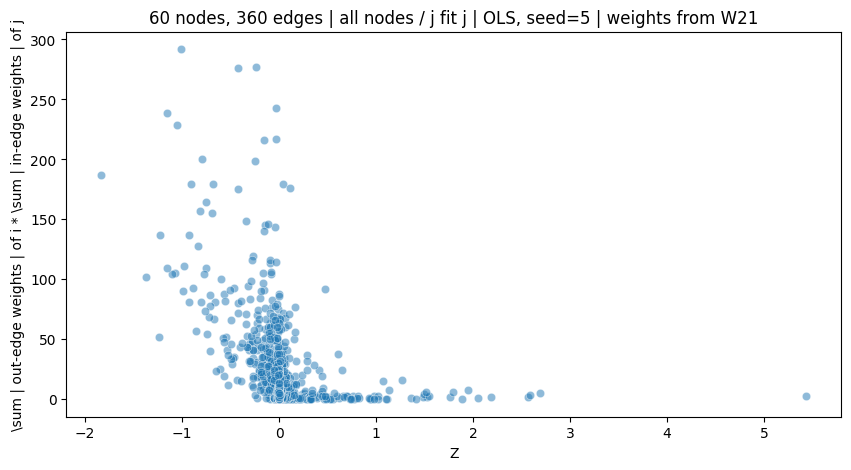

In [367]:
plt.figure(figsize=(10, 5))
n_out_w = {}
n_in_w = {}

for n in G_true.nodes:
    n_out_w[n] = 0.
    n_in_w[n] = 0.
    for _, j, w in G21.out_edges(n, data='weight'):
        n_out_w[n] += abs(w)
    for i, _, w in G21.in_edges(n, data='weight'):
        n_in_w[n] += abs(w)

Z_2_inout_deg = {}
for i, j, z in G_Z_null.edges(data='weight'):
    Z_2_inout_deg[n_out_w[i] * n_in_w[j]] = z

sns.scatterplot(x=list(Z_2_inout_deg.values()), y=list(Z_2_inout_deg.keys()), alpha=0.5)
plt.xlabel("Z")
plt.ylabel("\sum | out-edge weights | of i * \sum | in-edge weights | of j")
plt.title("60 nodes, 360 edges | all nodes / j fit j | OLS, seed=5 | weights from W21")

In [248]:
Z = np.abs(W11) - np.abs(W21)
fdr = 0.2
t_list = np.concatenate(([0], np.sort(np.unique(np.abs(Z)))))
t_last = np.inf
fdr_est_last = None
T_T_true = np.abs(W_true)
mask = (T_T_true > 0.)
T_T_true[mask], T_T_true[~mask] = 1, 0

for t in reversed(t_list):
    if t < 0.:
        break
    
    fdr_est = (1 + (Z <= -t).sum()) / np.max((1, (Z >= t).sum()))
    
    T_T = Z.copy()
    mask = (T_T >= t)
    T_T[mask], T_T[~mask] = 1, 0
    perf = utils_dagma.count_accuracy_simplify(T_T_true, T_T)
    fdr_true, power = perf['fdr'], perf['tpr']

    print(f"thresh {t:.4f} | est fdr {fdr_est:.4f} | true fdr {fdr_true:.4f} | true power {power:.4f}")

    if fdr_est <= fdr:
        t_last = t
        fdr_est_last = fdr_est

thresh 5.4312 | est fdr 1.0000 | true fdr 1.0000 | true power 0.0000
thresh 3.1110 | est fdr 2.0000 | true fdr 1.0000 | true power 0.0000
thresh 2.7279 | est fdr 1.0000 | true fdr 0.5000 | true power 0.0028
thresh 2.6883 | est fdr 0.6667 | true fdr 0.6667 | true power 0.0028
thresh 2.5829 | est fdr 0.5000 | true fdr 0.7500 | true power 0.0028
thresh 2.5637 | est fdr 0.4000 | true fdr 0.8000 | true power 0.0028
thresh 2.4379 | est fdr 0.3333 | true fdr 0.6667 | true power 0.0056
thresh 2.2980 | est fdr 0.2857 | true fdr 0.5714 | true power 0.0083
thresh 2.1872 | est fdr 0.2500 | true fdr 0.6250 | true power 0.0083
thresh 2.0547 | est fdr 0.2222 | true fdr 0.6667 | true power 0.0083
thresh 1.9614 | est fdr 0.2000 | true fdr 0.6000 | true power 0.0111
thresh 1.9561 | est fdr 0.1818 | true fdr 0.5455 | true power 0.0139
thresh 1.9471 | est fdr 0.1667 | true fdr 0.5833 | true power 0.0139
thresh 1.9171 | est fdr 0.1538 | true fdr 0.5385 | true power 0.0167
thresh 1.8899 | est fdr 0.1429 | t

## all nodes / j fit j | OLS, seed=6
* all true fdp > 0.2
* est fdp always > true fdp
* no edges being selected

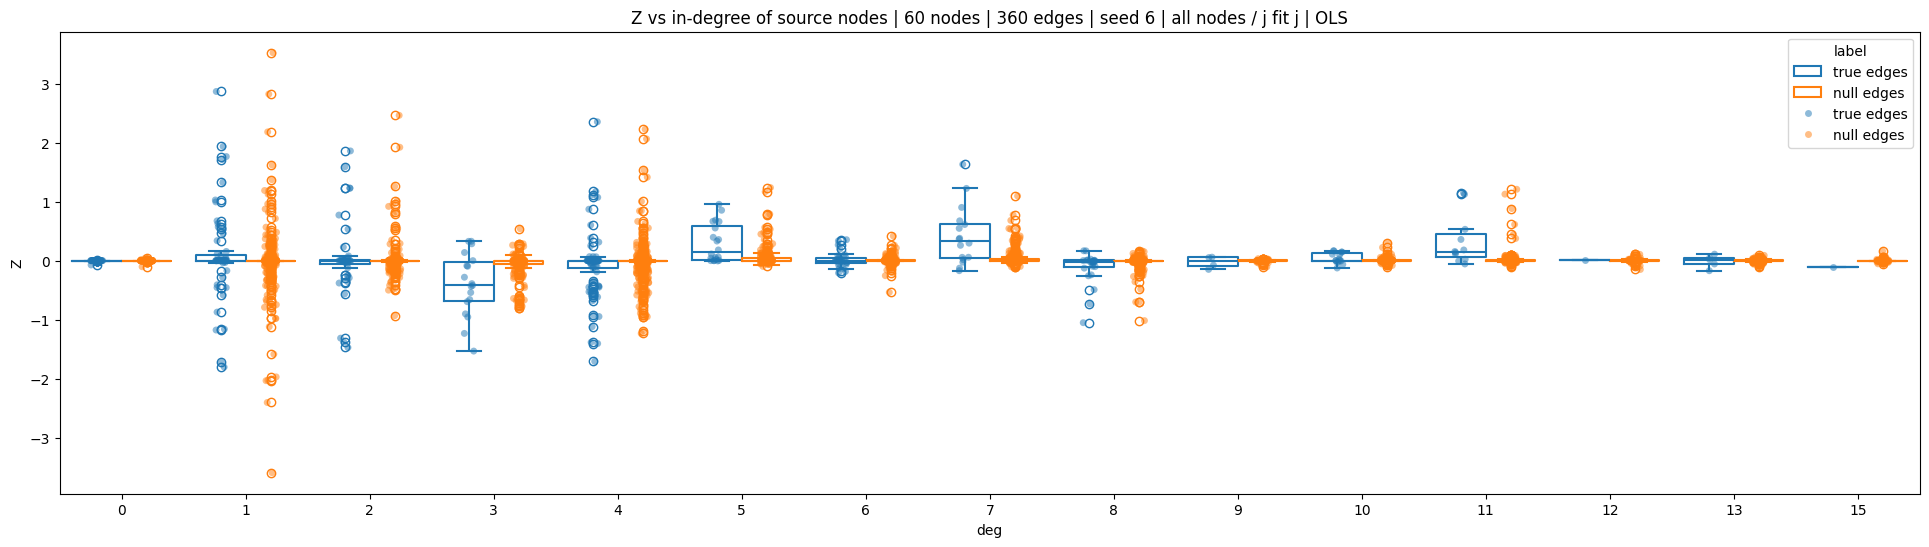

In [24]:
n_nodes = 60
s0 = 6
n_edges = n_nodes * s0
df, W11, W21, W_true = sys_z0_vs_deg_box(n_nodes, f'v44/v{n_nodes}_{n_edges}_option_5_OLS', notes='all nodes / j fit j | OLS', s0=s0, seed=6)

In [25]:
Z = np.abs(W11) - np.abs(W21)
fdr = 0.2
t_list = np.concatenate(([0], np.sort(np.unique(np.abs(Z)))))
t_last = np.inf
fdr_est_last = None
T_T_true = np.abs(W_true)
mask = (T_T_true > 0.)
T_T_true[mask], T_T_true[~mask] = 1, 0

for t in reversed(t_list):
    if t < 0.:
        break
    
    fdr_est = (1 + (Z <= -t).sum()) / np.max((1, (Z >= t).sum()))
    
    T_T = Z.copy()
    mask = (T_T >= t)
    T_T[mask], T_T[~mask] = 1, 0
    perf = utils_dagma.count_accuracy_simplify(T_T_true, T_T)
    fdr_true, power = perf['fdr'], perf['tpr']

    print(f"thresh {t:.4f} | est fdr {fdr_est:.4f} | true fdr {fdr_true:.4f} | true power {power:.4f}")

    if fdr_est <= fdr:
        t_last = t
        fdr_est_last = fdr_est

thresh 3.5973 | est fdr 2.0000 | true fdr 0.0000 | true power 0.0000
thresh 3.5273 | est fdr 2.0000 | true fdr 1.0000 | true power 0.0000
thresh 2.8699 | est fdr 1.0000 | true fdr 0.5000 | true power 0.0028
thresh 2.8257 | est fdr 0.6667 | true fdr 0.6667 | true power 0.0028
thresh 2.4649 | est fdr 0.5000 | true fdr 0.7500 | true power 0.0028
thresh 2.4061 | est fdr 0.7500 | true fdr 0.7500 | true power 0.0028
thresh 2.3556 | est fdr 0.6000 | true fdr 0.6000 | true power 0.0056
thresh 2.2289 | est fdr 0.5000 | true fdr 0.6667 | true power 0.0056
thresh 2.1842 | est fdr 0.4286 | true fdr 0.7143 | true power 0.0056
thresh 2.0655 | est fdr 0.3750 | true fdr 0.7500 | true power 0.0056
thresh 2.0355 | est fdr 0.5000 | true fdr 0.7500 | true power 0.0056
thresh 2.0291 | est fdr 0.6250 | true fdr 0.7500 | true power 0.0056
thresh 1.9718 | est fdr 0.7500 | true fdr 0.7500 | true power 0.0056
thresh 1.9374 | est fdr 0.6667 | true fdr 0.6667 | true power 0.0083
thresh 1.9235 | est fdr 0.6000 | t

## all nodes / j fit j | OLS, seed=8
* all true fdp > 0.2
* when large threshold, est fdp < true fdp. other cases nice.
* no edges being selected

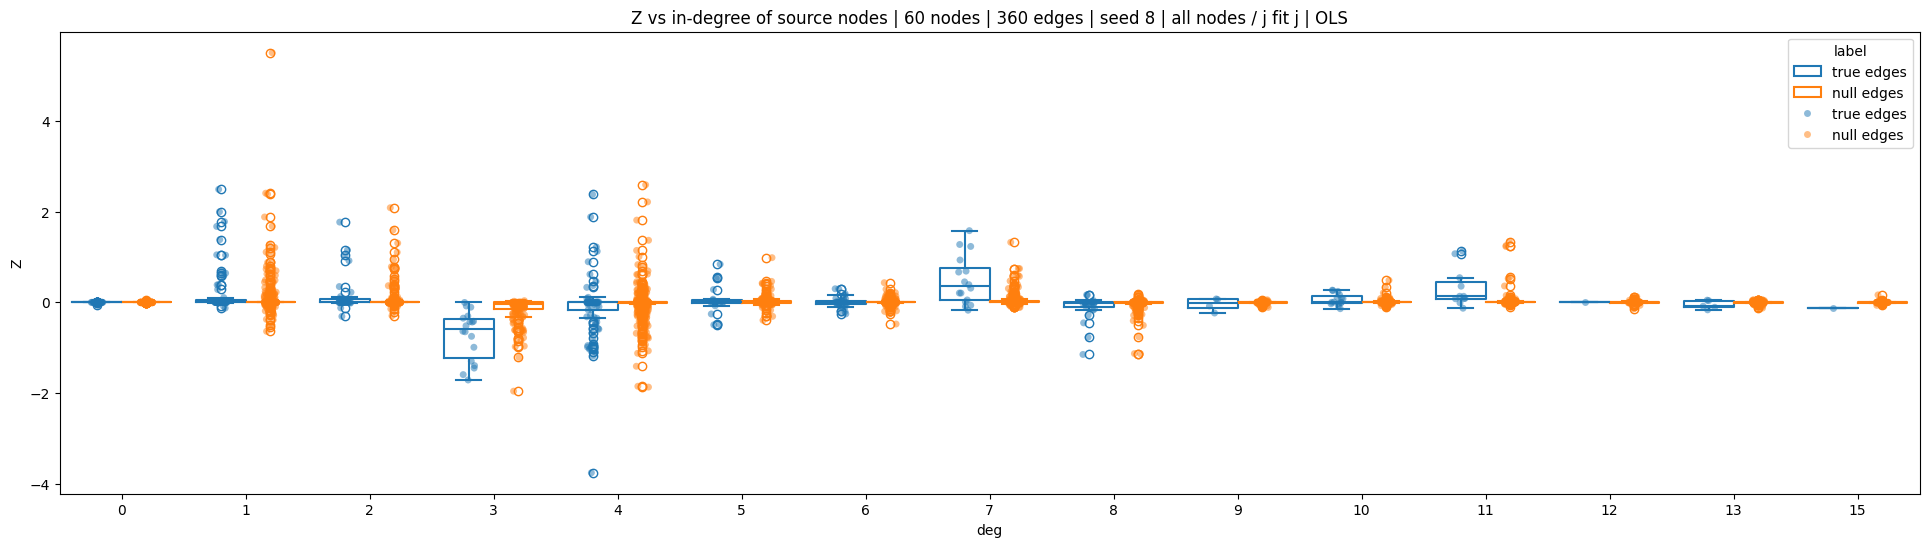

In [28]:
n_nodes = 60
s0 = 6
n_edges = n_nodes * s0
df, W11, W21, W_true = sys_z0_vs_deg_box(n_nodes, f'v44/v{n_nodes}_{n_edges}_option_5_OLS', notes='all nodes / j fit j | OLS', s0=s0, seed=8)

In [29]:
Z = np.abs(W11) - np.abs(W21)
fdr = 0.2
t_list = np.concatenate(([0], np.sort(np.unique(np.abs(Z)))))
t_last = np.inf
fdr_est_last = None
T_T_true = np.abs(W_true)
mask = (T_T_true > 0.)
T_T_true[mask], T_T_true[~mask] = 1, 0

for t in reversed(t_list):
    if t < 0.:
        break
    
    fdr_est = (1 + (Z <= -t).sum()) / np.max((1, (Z >= t).sum()))
    
    T_T = Z.copy()
    mask = (T_T >= t)
    T_T[mask], T_T[~mask] = 1, 0
    perf = utils_dagma.count_accuracy_simplify(T_T_true, T_T)
    fdr_true, power = perf['fdr'], perf['tpr']

    print(f"thresh {t:.4f} | est fdr {fdr_est:.4f} | true fdr {fdr_true:.4f} | true power {power:.4f}")

    if fdr_est <= fdr:
        t_last = t
        fdr_est_last = fdr_est

thresh 5.5119 | est fdr 1.0000 | true fdr 1.0000 | true power 0.0000
thresh 3.7615 | est fdr 2.0000 | true fdr 1.0000 | true power 0.0000
thresh 2.5961 | est fdr 1.0000 | true fdr 1.0000 | true power 0.0000
thresh 2.4949 | est fdr 0.6667 | true fdr 0.6667 | true power 0.0028
thresh 2.4107 | est fdr 0.5000 | true fdr 0.7500 | true power 0.0028
thresh 2.3889 | est fdr 0.4000 | true fdr 0.8000 | true power 0.0028
thresh 2.3827 | est fdr 0.3333 | true fdr 0.6667 | true power 0.0056
thresh 2.2179 | est fdr 0.2857 | true fdr 0.7143 | true power 0.0056
thresh 2.0893 | est fdr 0.2500 | true fdr 0.7500 | true power 0.0056
thresh 1.9992 | est fdr 0.2222 | true fdr 0.6667 | true power 0.0083
thresh 1.9605 | est fdr 0.3333 | true fdr 0.6667 | true power 0.0083
thresh 1.8855 | est fdr 0.3000 | true fdr 0.6000 | true power 0.0111
thresh 1.8850 | est fdr 0.2727 | true fdr 0.6364 | true power 0.0111
thresh 1.8709 | est fdr 0.3636 | true fdr 0.6364 | true power 0.0111
thresh 1.8525 | est fdr 0.4545 | t

# 80, 480

## others

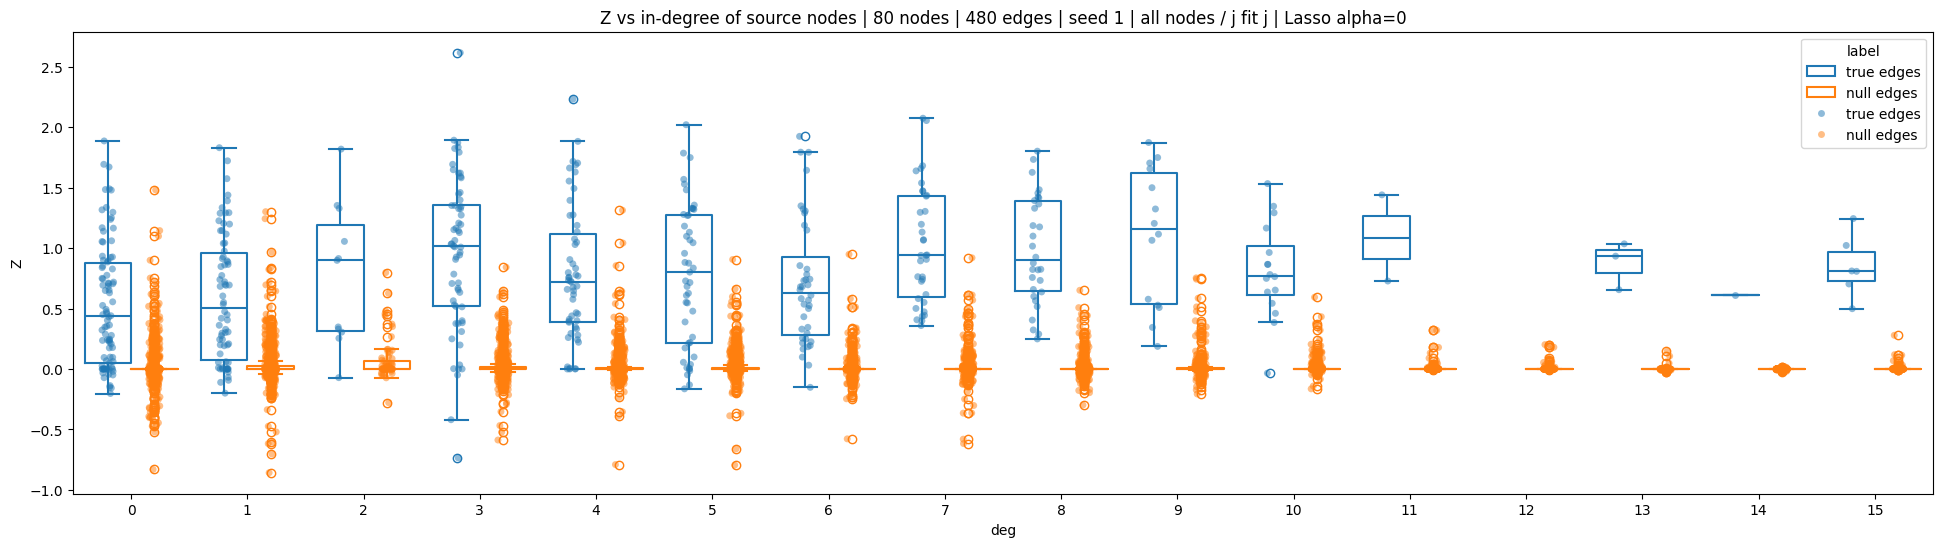

In [44]:
n_nodes = 80
s0 = 6
n_edges = n_nodes * s0
df = sys_z0_vs_deg_box(n_nodes, f'v44/v{n_nodes}_{n_edges}_option_5_lasso_OLS', notes='all nodes / j fit j | Lasso alpha=0', s0=s0)

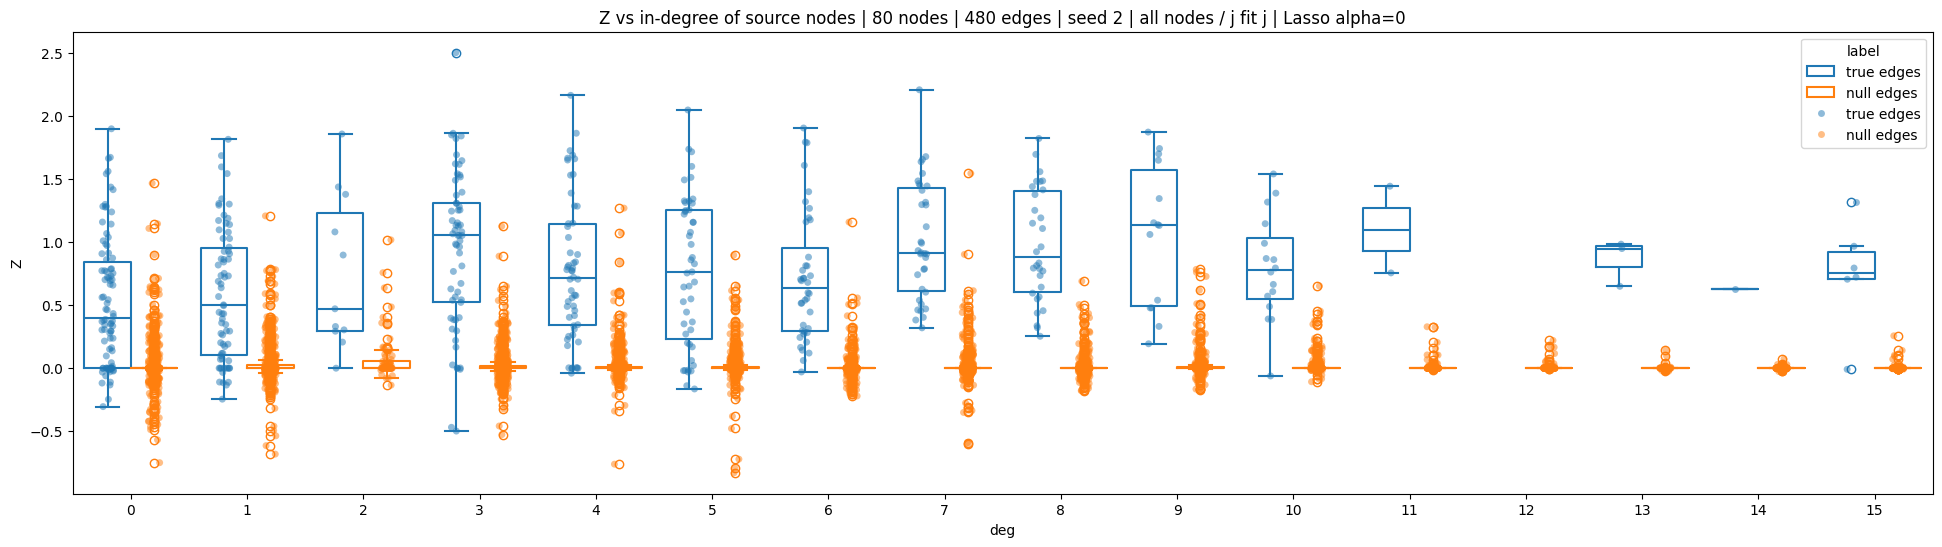

In [45]:
n_nodes = 80
s0 = 6
n_edges = n_nodes * s0
df = sys_z0_vs_deg_box(n_nodes, f'v44/v{n_nodes}_{n_edges}_option_5_lasso_OLS', notes='all nodes / j fit j | Lasso alpha=0', s0=s0, seed=2)

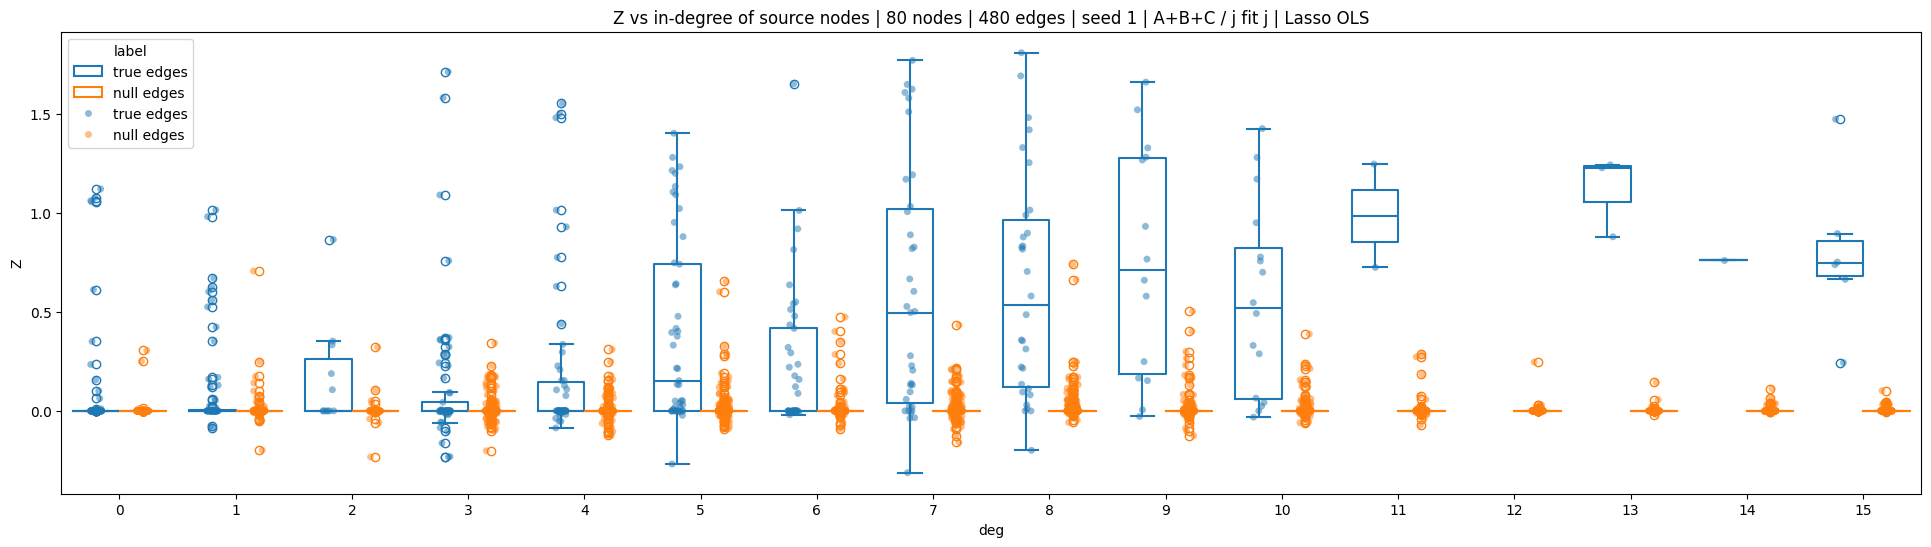

In [46]:
n_nodes = 80
s0 = 6
n_edges = n_nodes * s0
df, W11, W21 = sys_z0_vs_deg_box(n_nodes, f'v44/v{n_nodes}_{n_edges}_option_1_lasso_OLS', notes='A+B+C / j fit j | Lasso OLS', s0=s0)

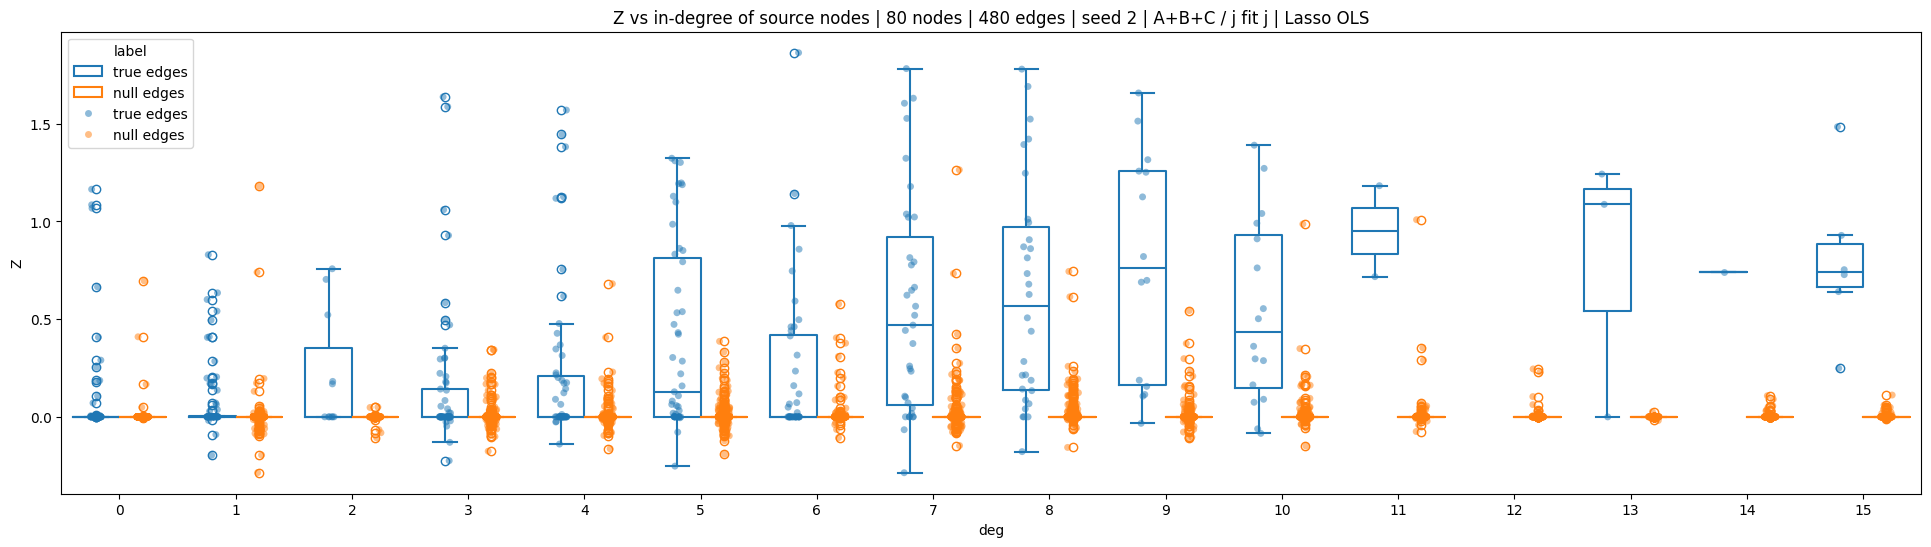

In [47]:
n_nodes = 80
s0 = 6
n_edges = n_nodes * s0
df, W11, W21 = sys_z0_vs_deg_box(n_nodes, f'v44/v{n_nodes}_{n_edges}_option_1_lasso_OLS', notes='A+B+C / j fit j | Lasso OLS', s0=s0, seed=2)

## all nodes / j fit j | OLS, seed=1

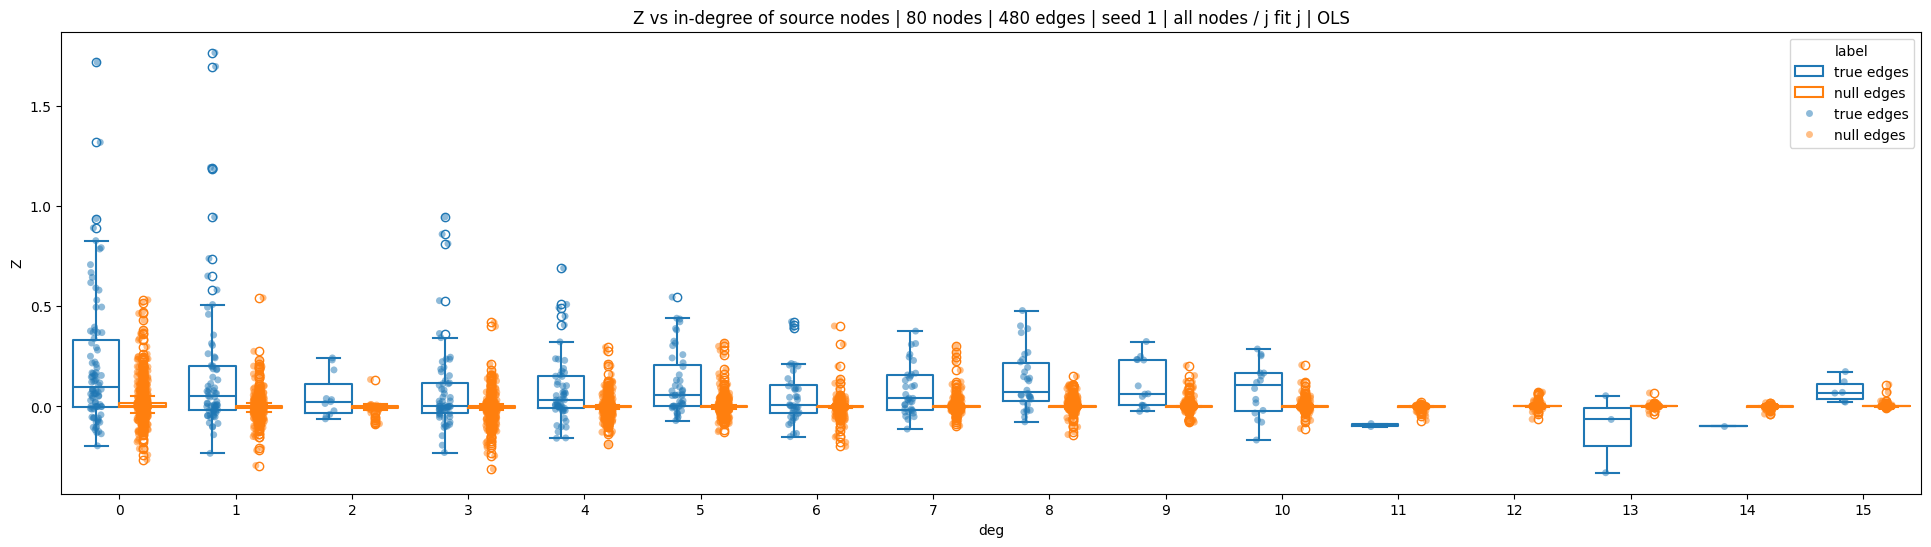

In [33]:
n_nodes = 80
s0 = 6
n_edges = n_nodes * s0
df, W11, W21, W_true = sys_z0_vs_deg_box(n_nodes, f'v44/v{n_nodes}_{n_edges}_option_5_OLS', notes='all nodes / j fit j | OLS', s0=s0)

In [34]:
Z = np.abs(W11) - np.abs(W21)
fdr = 0.2
t_list = np.concatenate(([0], np.sort(np.unique(np.abs(Z)))))
t_last = np.inf
fdr_est_last = None
T_T_true = np.abs(W_true)
mask = (T_T_true > 0.)
T_T_true[mask], T_T_true[~mask] = 1, 0

for t in reversed(t_list):
    if t < 0.:
        break
    
    fdr_est = (1 + (Z <= -t).sum()) / np.max((1, (Z >= t).sum()))
    
    T_T = Z.copy()
    mask = (T_T >= t)
    T_T[mask], T_T[~mask] = 1, 0
    perf = utils_dagma.count_accuracy_simplify(T_T_true, T_T)
    fdr_true, power = perf['fdr'], perf['tpr']

    print(f"thresh {t:.4f} | est fdr {fdr_est:.4f} | true fdr {fdr_true:.4f} | true power {power:.4f}")

    if fdr_est <= fdr:
        t_last = t
        fdr_est_last = fdr_est

thresh 1.7659 | est fdr 1.0000 | true fdr 0.0000 | true power 0.0021
thresh 1.7184 | est fdr 0.5000 | true fdr 0.0000 | true power 0.0042
thresh 1.6971 | est fdr 0.3333 | true fdr 0.0000 | true power 0.0063
thresh 1.3187 | est fdr 0.2500 | true fdr 0.0000 | true power 0.0083
thresh 1.1930 | est fdr 0.2000 | true fdr 0.0000 | true power 0.0104
thresh 1.1853 | est fdr 0.1667 | true fdr 0.0000 | true power 0.0125
thresh 0.9462 | est fdr 0.1429 | true fdr 0.0000 | true power 0.0146
thresh 0.9459 | est fdr 0.1250 | true fdr 0.0000 | true power 0.0167
thresh 0.9382 | est fdr 0.1111 | true fdr 0.0000 | true power 0.0187
thresh 0.8911 | est fdr 0.1000 | true fdr 0.0000 | true power 0.0208
thresh 0.8602 | est fdr 0.0909 | true fdr 0.0000 | true power 0.0229
thresh 0.8279 | est fdr 0.0833 | true fdr 0.0000 | true power 0.0250
thresh 0.8127 | est fdr 0.0769 | true fdr 0.0000 | true power 0.0271
thresh 0.7926 | est fdr 0.0714 | true fdr 0.0000 | true power 0.0292
thresh 0.7860 | est fdr 0.0667 | t

## all nodes / j fit j | OLS, seed=2

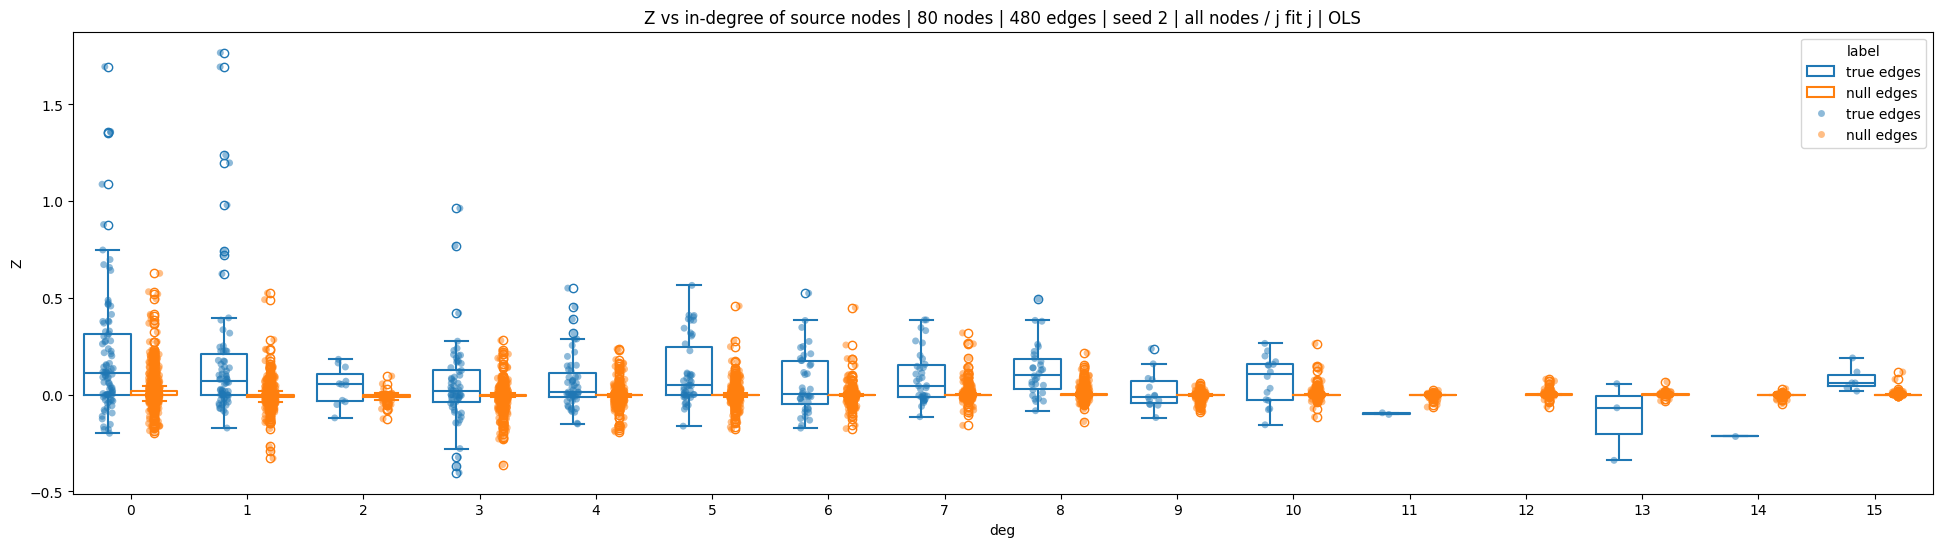

In [36]:
n_nodes = 80
s0 = 6
n_edges = n_nodes * s0
df, W11, W21, W_true = sys_z0_vs_deg_box(n_nodes, f'v44/v{n_nodes}_{n_edges}_option_5_OLS', notes='all nodes / j fit j | OLS', s0=s0, seed=2)

In [37]:
Z = np.abs(W11) - np.abs(W21)
fdr = 0.2
t_list = np.concatenate(([0], np.sort(np.unique(np.abs(Z)))))
t_last = np.inf
fdr_est_last = None
T_T_true = np.abs(W_true)
mask = (T_T_true > 0.)
T_T_true[mask], T_T_true[~mask] = 1, 0

for t in reversed(t_list):
    if t < 0.:
        break
    
    fdr_est = (1 + (Z <= -t).sum()) / np.max((1, (Z >= t).sum()))
    
    T_T = Z.copy()
    mask = (T_T >= t)
    T_T[mask], T_T[~mask] = 1, 0
    perf = utils_dagma.count_accuracy_simplify(T_T_true, T_T)
    fdr_true, power = perf['fdr'], perf['tpr']

    print(f"thresh {t:.4f} | est fdr {fdr_est:.4f} | true fdr {fdr_true:.4f} | true power {power:.4f}")

    if fdr_est <= fdr:
        t_last = t
        fdr_est_last = fdr_est

thresh 1.7674 | est fdr 1.0000 | true fdr 0.0000 | true power 0.0021
thresh 1.6953 | est fdr 0.5000 | true fdr 0.0000 | true power 0.0042
thresh 1.6942 | est fdr 0.3333 | true fdr 0.0000 | true power 0.0063
thresh 1.3601 | est fdr 0.2500 | true fdr 0.0000 | true power 0.0083
thresh 1.3551 | est fdr 0.2000 | true fdr 0.0000 | true power 0.0104
thresh 1.2393 | est fdr 0.1667 | true fdr 0.0000 | true power 0.0125
thresh 1.1981 | est fdr 0.1429 | true fdr 0.0000 | true power 0.0146
thresh 1.0877 | est fdr 0.1250 | true fdr 0.0000 | true power 0.0167
thresh 0.9803 | est fdr 0.1111 | true fdr 0.0000 | true power 0.0187
thresh 0.9637 | est fdr 0.1000 | true fdr 0.0000 | true power 0.0208
thresh 0.8796 | est fdr 0.0909 | true fdr 0.0000 | true power 0.0229
thresh 0.7696 | est fdr 0.0833 | true fdr 0.0000 | true power 0.0250
thresh 0.7479 | est fdr 0.0769 | true fdr 0.0000 | true power 0.0271
thresh 0.7436 | est fdr 0.0714 | true fdr 0.0000 | true power 0.0292
thresh 0.7218 | est fdr 0.0667 | t